### Import Packages & Functions

#### Packages

In [1]:
# Basics
import warnings
warnings.simplefilter('ignore')

import numpy as np # for manipulating ndarrays
import matplotlib.pyplot as plt # For plotting
import tensorflow as tf # machine learning pacakge
import pandas as pd  # for reading and saving table files
import scipy.io # for importing mat dataset
import random

# Sklearn Models: Import conventional machine learning models from Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import InputLayer
from keras.initializers import glorot_uniform
from tensorflow.keras.initializers import HeNormal

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Sklearn Auxillary
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc

# For convenient plotting
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import matplotlib.image as mpimg

# Miscellaneous (IO operation)
from tensorflow.keras.utils import plot_model
import scipy.io as sio
import h5py # used to read the MATLAB data files.
import os
import re
import pickle
from time import sleep, strftime
from functools import partial

# Selenium Webdriver: used to construct a web interface for interactive case study 
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

# Web Map Tile Service
# See https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/gibs for more info
from owslib.wmts import WebMapTileService

# IPython Widgets
import ipywidgets as widgets
import IPython.display as display
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots

# Calculating SHAP value for machine learning methods
import shap 

2024-10-29 07:47:03.289225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 07:47:03.452402: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2019.2.187/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2019.2.187/linux/mpi/intel64/libfabric/lib:/opt/intel/compilers_and_libraries_2019.2.187/linux/mpi/intel64/lib/release:/opt/intel/compilers_and_libraries_2019.2.187/linux/mpi/intel64/lib:/opt/intel/compilers_and_libraries_2019.2.187/linux/ipp/lib/intel64:/opt/intel/compilers_and_libra

#### Functions

##### Helper Function

In [2]:
# Save Figure
def save_fig(fig_id, IMAGES_PATH, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Configuration of TensorBoard
def get_run_logdir(root_logdir):
    run_id = strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

# Save & Load Scikit-learn model
def mod_save(var, filename, mod_path):
    pickle.dump(var, open(os.path.join(mod_path, filename), 'wb'))
    
def mod_load(filename, mod_path):
    return pickle.load(open(os.path.join(mod_path, filename), 'rb'))

def mod_check(filename, mod_path):
    return os.path.exists(os.path.join(mod_path, filename))

# The following function determines whether the model has been trained before. If it is, the parameters will be loaded from the file.
def smart_training(model, file_name, X_train, y_train, mod_path, kwargs=None):
    if mod_check(file_name, mod_path):
        print('WARNING: Loading from the existing model.')
        return mod_load(file_name, mod_path)
    else:
        print("Training model")
        mod = model(**kwargs).fit(X_train, y_train)
        mod_save(mod, file_name, mod_path)
        return mod

# The following function transfer radiance into brightness temperature
def brightT(wnumber, radiance):
    # Ensure wnumber and radiance are numpy arrays
    wnumber = np.array(wnumber)
    radiance = np.array(radiance)

    # Constants
    AVOGAD = 6.02297E+23
    BOLTZMNS = 1.38062E-23
    PLANCKS = 6.62620E-34
    CLIGHT = 2.99793E+10

    PLCON1 = 1.191043934e-5
    PLCON2 = 1.438769911

    # Convert radiance to mW per square meter per cm-1 per ster
    radiance = radiance * 1e7

    # Reshape wnumber for broadcasting
    wnumber = wnumber.reshape(1, 1, -1)  # Shape (1, 1, 1551)

    # Calculate brightness temperature
    BT = (PLCON2 * wnumber) / np.log(1.0 + PLCON1 * (wnumber ** 3) / radiance)

    return BT

##### Plotting functions

In [3]:
# Plot the spectrum
def plot_spectrum(freq, Tclear, Tcloud, ax=None):
    if ax is None:
        plt.plot(freq,Tclear,'r',label='Clear Sky')
        plt.plot(freq,Tcloud,'b',label='Cloudy Sky')
        plt.ylabel('Brightness Temperature (K)')
        plt.xlabel('Wavenumber ($cm^{-1}$)')
        plt.legend()
    else:
        ax.plot(freq,Tclear,'r',label='Clear Sky')
        ax.plot(freq,Tcloud,'b',label='Cloudy Sky')
        ax.set_ylabel('Brightness Temperature (K)')
        ax.set_xlabel('Wavenumber ($cm^{-1}$)')

# Plot the spectrum backdrop
def plot_spectrum_bg(ax):
    ax.plot(freq2_new[0],BTwin[np.equal(cloud_flag,0).squeeze()].mean(axis=0),
            'r', label='Clear Sky', alpha=0.2)
    ax.plot(freq2_new[0],BTwin[np.equal(cloud_flag,1).squeeze()].mean(axis=0),
            'b', label='Cloudy Sky', alpha=0.2)
    
# Plot the confusion matrix
def plot_confusion_matrix_2(y_pred, y_true, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None,
                          cmap='viridis', ax=None):

    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            raise ValueError("labels must be provided")
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

def plot_2D_scatter(X, y_true, y_pred, ax=None):
    colors = np.array(['red', 'blue'])
    correct_pred = np.equal(y_true, y_pred)
    wrong_pred = np.logical_not(correct_pred)
    if ax is None:
        plt.figure(figsize=(10,6))
        plt.scatter(X[correct_pred,0], X[correct_pred,1], c=colors[y_true[correct_pred]], marker='.', alpha=0.5)
        plt.scatter(X[wrong_pred,0], X[wrong_pred,1], c=colors[y_true[wrong_pred]],
                    marker='x', alpha=0.5)
        plt.xlabel('X1')
        plt.ylabel('X2')
        legend_handles = [
            Line2D([], [], ls='None', marker='.', c=colors[0]),
            Line2D([], [], ls='None', marker='.', c=colors[1]),
            Line2D([], [], ls='None', marker='.', c='k'),
            Line2D([], [], ls='None', marker='x', c='k'),
        ]
        plt.legend(legend_handles, ['Clear Sky', 'Cloudy Sky', 'Correct', 'Incorrect'])
    else:
        ax.scatter(X[correct_pred,0], X[correct_pred,1], c=colors[y_true[correct_pred]], marker='.', alpha=0.5)
        ax.scatter(X[wrong_pred,0], X[wrong_pred,1], c=colors[y_true[wrong_pred]],
                    marker='x', alpha=0.5)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        legend_handles = [
            Line2D([], [], ls='None', marker='.', c=colors[0]),
            Line2D([], [], ls='None', marker='.', c=colors[1]),
            Line2D([], [], ls='None', marker='.', c='k'),
            Line2D([], [], ls='None', marker='x', c='k'),
        ]
        ax.legend(legend_handles, ['Clear Sky', 'Cloudy Sky', 'Correct', 'Incorrect'])

# Plot AUC Curve
def plot_auc_curve(fpr, tpr, ax):
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange',
             lw=2.0, label='ROC curve (area = %0.3f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='gray', lw=1.0, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

def plot_roc_auc(y_true, y_score, ax):
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    plot_auc_curve(fpr, tpr, ax)
    index = np.sum(threshold>0.0) - 1
    ax.plot(fpr[index], tpr[index], '*r')

def plot_cv_acc(param, cv, ax, xlog=False):
    ax.errorbar(param, cv.cv_results_['mean_train_score'],
                yerr=cv.cv_results_['std_train_score'],
                fmt='r.-', label='Training Accuracy')
    ax.errorbar(param, cv.cv_results_['mean_test_score'],
                yerr=cv.cv_results_['std_test_score'],
                fmt='b.-', label='Test Accuracy')
    ax.set_ylabel('Accuracy')
    if xlog:
        ax.set_xscale('log')
    ax.legend()
    return ax



##### Dimensionality Reduction Function

In [4]:
# Forward Selection Method (Bottleneck)
def select_bottleneck_channels_iteratively(X_train, X_test, n_bottleneck_channels, selected_channels):
    """
    Iteratively selects the best channels (features) that minimize reconstruction error when used in a linear regression model.

    Parameters:
    - n_bottleneck_channels: Number of channels (features) to select.

    Returns:
    - selected_channels: List of indices of the selected channels.
    """
    n_samples, n_features = X_train.shape
    #selected_channels = []

    for _ in range(n_bottleneck_channels):
        lowest_error = float('inf')
        best_channel = None

        # Evaluate each channel that is not already selected
        for channel in range(n_features):
            if channel in selected_channels:
                continue

            # Temporarily add the channel to the selected channels
            temp_channels = selected_channels + [channel]
            X_train_temp = X_train[:, temp_channels]
            X_test_temp = X_test[:, temp_channels]

            # Train a linear regression model using the selected channels
            model = LinearRegression()
            model.fit(X_train_temp, X_train)

            # Predict the test set
            X_test_pred = model.predict(X_test_temp)

            # Calculate the reconstruction error
            error = mean_squared_error(X_test, X_test_pred)

            # Update the best channel if the current error is lower
            if error < lowest_error:
                best_channel = channel
                lowest_error = error

        # Add the best channel to the selected channels
        selected_channels.append(best_channel)
        print(f"Selected channel {best_channel} with error {lowest_error}")

    return selected_channels


In [5]:
# Principal Component Analysis
def perform_pca(X_train_std_ori, X_valid_std_ori, X_test_std_ori, pca_number, mod_path):
    """
    Perform PCA on the input datasets and return the transformed datasets.

    Parameters:
    - X_train_std_ori: The standardized training dataset with SST.
    - X_valid_std_ori: The standardized validation dataset with SST.
    - X_test_std_ori: The standardized test dataset with SST.
    - pca_number: The number of principal components to keep.

    Returns:
    - x_train_latent: The transformed training dataset with PCA components and the SST.
    - x_valid_latent: The transformed validation dataset with PCA components and the SST.
    - x_test_latent: The transformed test dataset with PCA components and the SST.
    """

    # Check if the model already exists
    model_filename = f'CL_MOD_PCA_new_{pca_number}.dat'
    
    if mod_check(model_filename, mod_path):
        print('WARNING: Loading from the existing PCA model.')
        pca = mod_load(model_filename, mod_path)
    else:
        # Train the model
        # Initialize PCA with the specified number of components
        pca = PCA(n_components=pca_number)
        # Fit PCA on the training data and transform the datasets
        pca.fit_transform(X_train_std_ori[:, :-1])
        mod_save(pca, model_filename, mod_path)
    
    X_train_std_BTwin = pca.transform(X_train_std_ori[:, :-1])
    X_valid_std_BTwin = pca.transform(X_valid_std_ori[:, :-1])
    X_test_std_BTwin = pca.transform(X_test_std_ori[:, :-1])
    
    # Concatenate the PCA-transformed data with the last column of the original data
    x_train_latent = np.concatenate((X_train_std_BTwin, X_train_std_ori[:, -1].reshape((X_train_std_ori.shape[0], 1))), axis=1)
    x_valid_latent = np.concatenate((X_valid_std_BTwin, X_valid_std_ori[:, -1].reshape((X_valid_std_ori.shape[0], 1))), axis=1)
    x_test_latent = np.concatenate((X_test_std_BTwin, X_test_std_ori[:, -1].reshape((X_test_std_ori.shape[0], 1))), axis=1)
    
    return x_train_latent, x_valid_latent, x_test_latent

In [6]:
# Feed-Forward Autoencoder
# Define the Autoencoder model
class Autoencoder(Model):
    def __init__(self, latent_dim, input_shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
            
        # Encoder
        # layers.Dense(512, activation='elu', input_shape=(input_shape,), use_bias=False, 
        #             kernel_initializer=glorot_uniform()),
        self.encoder = tf.keras.Sequential([
            layers.Dense(latent_dim, input_shape=(input_shape,), kernel_initializer=HeNormal())
        ])
            
        # Decoder
        # layers.Dense(input_shape, activation='elu')
        # layers.BatchNormalization(),
        # layers.Dense(1024, activation='relu'),
        # layers.BatchNormalization(),
        self.decoder = tf.keras.Sequential([
            layers.Dense(64, kernel_regularizer='l2', activation='LeakyReLU', input_shape=(latent_dim,)),
            layers.Dense(input_shape)
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_latent_representation(self, x):
        return self.encoder(x)
    
def perform_autoencoder(X_train_std_ori, X_valid_std_ori, X_test_std_ori, input_shape=1551, latent_dim=80, epochs=10, test_size=0.2, random_state=42):
    """
    Parameters:
    - input_shape: The dimensionality of the input data.
    - latent_dim: The dimensionality of the latent space.
    - epochs: Number of training epochs.
    - test_size: Proportion of the training set to include in the validation split.
    - random_state: Random seed for splitting the dataset.

    Returns:
    - x_train_latent: Latent representations for the training data and the SST.
    - x_valid_latent: Latent representations for the validation data and the SST.
    - x_test_latent: Latent representations for the test data and the SST.
    """
    
    # Initialize the MinMaxScaler and normalize the datasets
    scaler = MinMaxScaler()
    x_train_normalized = X_train_std_ori[:, :-1] 
    x_valid_normalized = X_valid_std_ori[:, :-1] 
    x_test_normalized = X_test_std_ori[:, :-1] 
    
    # Split the training dataset
    x_train_normalized_train, x_train_normalized_test = train_test_split(x_train_normalized, test_size=test_size, random_state=random_state)
    
    # Instantiate and compile the Autoencoder
    autoencoder = Autoencoder(latent_dim, input_shape)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    
    # Train the Autoencoder
    autoencoder.fit(x_train_normalized_train, x_train_normalized_train,
                    epochs=epochs,
                    shuffle=True,
                    validation_data=(x_train_normalized_test, x_train_normalized_test))
    
    # Get latent representations
    x_train_latent = autoencoder.get_latent_representation(x_train_normalized)
    x_valid_latent = autoencoder.get_latent_representation(x_valid_normalized)
    x_test_latent = autoencoder.get_latent_representation(x_test_normalized)
    
    # Convert latent representations to DataFrames
    x_train_latent = pd.DataFrame(x_train_latent.numpy())
    x_valid_latent = pd.DataFrame(x_valid_latent.numpy())
    x_test_latent = pd.DataFrame(x_test_latent.numpy())
    
    # Add the last column of the original data to the latent representations
    x_train_latent['new_column'] = X_train_std_ori[:, -1]
    x_valid_latent['new_column'] = X_valid_std_ori[:, -1]
    x_test_latent['new_column'] = X_test_std_ori[:, -1]
    
    return x_train_latent, x_valid_latent, x_test_latent


##### Classifiers Function

In [7]:
# Linear SVM
def train_or_load_svm_model(pca_number, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num, C_value=0.01):
    # Train the model

    # Check if the model already exists
    model_filename = f'CL_MOD_SVC_new_3_{pca_number}_{reduction_method}.dat'
    
    if mod_check(model_filename, mod_path):
        print('WARNING: Loading from the existing SVM model.')
        mod_svc = mod_load(model_filename, mod_path)
    else:
        # Train the model
        print("Training SVC model")
        mod_svc = LinearSVC(random_state=random_num, C=C_value)
        mod_svc.fit(x_train_latent, y_train)
        mod_save(mod_svc, model_filename, mod_path)

    # mod_svc = smart_training(LinearSVC, f'CL_MOD_SVC_new_1_{pca_number}_{reduction_method}.dat',
                            #   x_train_latent, y_train, mod_path, kwargs={'C': C_value})
    
    # Evaluate on training set
    y_pred_train = mod_svc.predict(x_train_latent)
    train_accuracy = accuracy_score(y_pred_train, y_train)
    train_confusion_matrix = confusion_matrix(y_train, y_pred_train)
    
    # Evaluate on validation set
    y_pred_valid = mod_svc.predict(x_valid_latent)
    valid_accuracy = accuracy_score(y_pred_valid, y_valid)
    valid_confusion_matrix = confusion_matrix(y_valid, y_pred_valid)
    
    # Evaluate on test set
    y_pred_test = mod_svc.predict(x_test_latent)
    test_accuracy = accuracy_score(y_pred_test, y_test)
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    return {
        'train': {'accuracy': train_accuracy, 'confusion_matrix': train_confusion_matrix},
        'valid': {'accuracy': valid_accuracy, 'confusion_matrix': valid_confusion_matrix},
        'test': {'accuracy': test_accuracy, 'confusion_matrix': test_confusion_matrix},
        'y_pred_test': y_pred_test
    }


In [8]:
# Random Forest
def train_or_load_forest_model(pca_number, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num, n_estimators=200, n_jobs=3):
    # Check if the model already exists
    model_filename = f'CL_MOD_FOREST_new_3_{pca_number}_{reduction_method}.dat'
    
    if mod_check(model_filename, mod_path):
        print('WARNING: Loading from the existing RF model.')
        mod_forest = mod_load(model_filename, mod_path)
    else:
        # Train the model
        print("Training RF model")
        mod_forest = RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs, random_state=random_num)
        mod_forest.fit(x_train_latent, y_train)
        mod_save(mod_forest, model_filename, mod_path)
    
    # Evaluate on training set
    y_pred_train = mod_forest.predict(x_train_latent)
    train_accuracy = accuracy_score(y_pred_train, y_train)
    train_confusion_matrix = confusion_matrix(y_train, y_pred_train)
    
    # Evaluate on validation set
    y_pred_valid = mod_forest.predict(x_valid_latent)
    valid_accuracy = accuracy_score(y_pred_valid, y_valid)
    valid_confusion_matrix = confusion_matrix(y_valid, y_pred_valid)
    
    # Evaluate on test set
    y_pred_test = mod_forest.predict(x_test_latent)
    test_accuracy = accuracy_score(y_pred_test, y_test)
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    return {
        'train': {'accuracy': train_accuracy, 'confusion_matrix': train_confusion_matrix},
        'valid': {'accuracy': valid_accuracy, 'confusion_matrix': valid_confusion_matrix},
        'test': {'accuracy': test_accuracy, 'confusion_matrix': test_confusion_matrix},
        'y_pred_test': y_pred_test
    }


In [9]:
# Gradient Boosting Classifier
def train_or_load_gb_model(pca_number, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num):
    # Check if the model already exists
    model_filename = f'CL_MOD_GB_new_{pca_number}_{reduction_method}.dat'
    
    if mod_check(model_filename, mod_path):
        print('WARNING: Loading from the existing GB model.')
        mod_gb = mod_load(model_filename, mod_path)
    else:
        print("Training GB model")
        # Train the model
        mod_gb = GradientBoostingClassifier(verbose=1, random_state=random_num)
        mod_gb.fit(x_train_latent, y_train)
        mod_save(mod_gb, model_filename, mod_path)
    
    # Evaluate on training set
    y_pred_train = mod_gb.predict(x_train_latent)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_confusion_matrix = confusion_matrix(y_train, y_pred_train)
    
    # Evaluate on validation set
    y_pred_valid = mod_gb.predict(x_valid_latent)
    valid_accuracy = accuracy_score(y_valid, y_pred_valid)
    valid_confusion_matrix = confusion_matrix(y_valid, y_pred_valid)
    
    # Evaluate on test set
    y_pred_test = mod_gb.predict(x_test_latent)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    return {
        'train': {'accuracy': train_accuracy, 'confusion_matrix': train_confusion_matrix},
        'valid': {'accuracy': valid_accuracy, 'confusion_matrix': valid_confusion_matrix},
        'test': {'accuracy': test_accuracy, 'confusion_matrix': test_confusion_matrix},
        'y_pred_test': y_pred_test
    }

In [10]:
# SGD Classifier
def train_or_load_sgd_model(pca_number, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num):
    # Check if the model already exists
    model_filename = f'CL_MOD_SGD_new_3_{pca_number}_{reduction_method}.dat'
    
    if mod_check(model_filename, mod_path):
        print('WARNING: Loading from the existing SGD model.')
        mod_sgd = mod_load(model_filename, mod_path)
    else:
        # Train the model
        print("Training SGD model")
        mod_sgd = SGDClassifier(random_state=random_num)
        mod_sgd.fit(x_train_latent, y_train)
        mod_save(mod_sgd, model_filename, mod_path)
    
    # Evaluate on training set
    y_pred_train = mod_sgd.predict(x_train_latent)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_confusion_matrix = confusion_matrix(y_train, y_pred_train)
    
    # Evaluate on validation set
    y_pred_valid = mod_sgd.predict(x_valid_latent)
    valid_accuracy = accuracy_score(y_valid, y_pred_valid)
    valid_confusion_matrix = confusion_matrix(y_valid, y_pred_valid)
    
    # Evaluate on test set
    y_pred_test = mod_sgd.predict(x_test_latent)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    return {
        'train': {'accuracy': train_accuracy, 'confusion_matrix': train_confusion_matrix},
        'valid': {'accuracy': valid_accuracy, 'confusion_matrix': valid_confusion_matrix},
        'test': {'accuracy': test_accuracy, 'confusion_matrix': test_confusion_matrix},
        'y_pred_test': y_pred_test
    }

In [11]:
# Feed-Forward Neural Network
def train_or_load_ann_model(x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, reduced_num, mod_path, root_logdir, reduction_method, epochs=30, validation_split=0.15):
    """
    Build and train a dense autoencoder model, save the best model, and evaluate its performance on the test set.

    Parameters:
    - x_train_latent: The latent space representation of the training data.
    - y_train: Labels for the training data.
    - x_test_latent: The latent space representation of the test data.
    - y_test: Labels for the test data.
    - reduced_num: The number of reduced features used.
    - mod_path: Path to save the trained model.
    - epochs: Number of epochs to train the model.
    - validation_split: Fraction of the training data to be used as validation data.

    Returns:
    - accuracy: Accuracy of the model on the test set.
    - conf_matrix: Confusion matrix of the model's predictions on the test set.
    """

    # Define the file name and path for saving the model
    filename = os.path.join(mod_path, f'CL_MOD_ANN_new_4_{reduced_num}_{reduction_method}_lr=0.00005,dropout=0.05-->moved,epoch={epochs}_ori.h5')

    if mod_check(filename, mod_path):
        print('WARNING: Loading from the existing NN model.')
        mod_ann_autoencoder = keras.models.load_model(filename)

    else:
        print("Training NN model")
        # Define the kernel constraint
        constraint = tf.keras.constraints.MinMaxNorm(min_value=-5, max_value=5, rate=1.0, axis=0)

        # Build the autoencoder model
        mod_ann_autoencoder = keras.models.Sequential([
            InputLayer(input_shape=(x_train_latent.shape[1], )),
            keras.layers.Dense(300, activation='elu', kernel_initializer='glorot_uniform'),
            keras.layers.Dense(200, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer='l2'),
            Dropout(0.05),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer='l2'),
            keras.layers.Dense(80, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer='l2'),
            keras.layers.Dense(50, activation='relu', kernel_initializer='glorot_uniform', kernel_constraint=constraint, kernel_regularizer='l2'),
            keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
        ])
    
        # Define the callbacks
        run_logdir = get_run_logdir(root_logdir)
        checkpoint_cb = keras.callbacks.ModelCheckpoint(filename, save_best_only=True)
        logger_cb = keras.callbacks.CSVLogger(filename + '.log', separator=',', append=False)

        # Compile the model
        mod_ann_autoencoder.compile(optimizer=keras.optimizers.Nadam(lr=0.00005, beta_1=0.995, beta_2=0.999),
                                loss='binary_crossentropy',
                                metrics=['accuracy'])

        # Shuffle the data manually before training, using NumPy
        np.random.seed(2020)
        shuffled_indices = np.random.permutation(len(x_train_latent))
        x_train_latent_shuffled = x_train_latent[shuffled_indices]
        y_train_shuffled = y_train[shuffled_indices]

        # Train the model
        mod_ann_autoencoder.fit(x_train_latent_shuffled, y_train_shuffled, epochs=epochs, shuffle=False, 
                            validation_split=validation_split,
                            callbacks=[checkpoint_cb, logger_cb])

    # Evaluate on training set
    y_pred_train = np.round(mod_ann_autoencoder.predict(x_train_latent))  # x_train_latent_shuffled
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_confusion_matrix = confusion_matrix(y_train, y_pred_train)
    
    # Evaluate on validation set
    y_pred_valid = np.round(mod_ann_autoencoder.predict(x_valid_latent))
    valid_accuracy = accuracy_score(y_valid, y_pred_valid)
    valid_confusion_matrix = confusion_matrix(y_valid, y_pred_valid)
    
    # Evaluate on test set
    y_pred_test = np.round(mod_ann_autoencoder.predict(x_test_latent))
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    return {
        'train': {'accuracy': train_accuracy, 'confusion_matrix': train_confusion_matrix},
        'valid': {'accuracy': valid_accuracy, 'confusion_matrix': valid_confusion_matrix},
        'test': {'accuracy': test_accuracy, 'confusion_matrix': test_confusion_matrix},
        'y_pred_test': y_pred_test
    }

In [12]:
# Thermal Contrast
# Thermal contrast algorithm determines cloudy scenes by contrasting the maximum brightness temperature over a spectrum 
# and the sea surface temperature from HadCRUT dataset. The difference is termed "decision function".

def SST_BT_max_contrast(bt, sst):
    return (sst - bt.max(axis=-1))

def train_thermal_contrast(x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test):
    y_train_tc = SST_BT_max_contrast(x_train_latent[:,:-1], x_train_latent[:,-1])
    y_valid_tc = SST_BT_max_contrast(x_valid_latent[:,:-1], x_valid_latent[:,-1])
    y_test_tc = SST_BT_max_contrast(x_test_latent[:,:-1], x_test_latent[:,-1])

    fpr, tpr, threshold = roc_curve(y_train, y_train_tc)
    index = np.sum(threshold>0.0) - 1
    optimal_threshold = threshold[index]

    # Evaluate on training set
    y_pred_train = (y_train_tc >= optimal_threshold).astype(int)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_confusion_matrix = confusion_matrix(y_train, y_pred_train)
    
    # Evaluate on validation set
    y_pred_valid = (y_valid_tc >= optimal_threshold).astype(int)
    valid_accuracy = accuracy_score(y_valid, y_pred_valid)
    valid_confusion_matrix = confusion_matrix(y_valid, y_pred_valid)
    
    # Evaluate on test set
    y_pred_test = (y_test_tc >= optimal_threshold).astype(int)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    return {
        'train': {'accuracy': train_accuracy, 'confusion_matrix': train_confusion_matrix},
        'valid': {'accuracy': valid_accuracy, 'confusion_matrix': valid_confusion_matrix},
        'test': {'accuracy': test_accuracy, 'confusion_matrix': test_confusion_matrix},
        'y_pred_test': y_pred_test
    }

In [13]:
# Bispectral Analysis
# Bispectral algorithm determines cloudy scenes by contrasting 8 um brightness temperature and 11 um brightness temperature.
def trispec_ackerman(wn, bt=None, radiance=None):
    if (radiance is not None):
        # input radiance must be in W/squre centimeter/cm-1/stdr
        # this fuction converts frequency and radiances to brightness temperature
        AVOGAD   = 6.02297E+23
        BOLTZMNS = 1.38062E-23
        PLANCKS  = 6.62620E-34
        CLIGHT   = 2.99793E+10

        PLCON1 = 1.191043934e-5
        PLCON2 = 1.438769911

        radiance = radiance * 1e7
        # convert radiance to mW per square meter per cm-1 per ster
        bt2 = (PLCON2 * wn) / np.log(1.0 + PLCON1 * (wn**3) / radiance);
        
    if (bt is not None):
        bt2 = np.copy(bt)

    # parameters in micron
    u8  = (8.1, 8.2)
    u11 = (11.06, 11.25)
    u12 = (11.93, 12.06)

    # find the indices
    ind_u8  = np.nonzero(np.logical_and(wn >= 1e4/u8[1], wn <= 1e4/u8[0]))[0]
    ind_u11 = np.nonzero(np.logical_and(wn >= 1e4/u11[1], wn <= 1e4/u11[0]))[0]
    ind_u12 = np.nonzero(np.logical_and(wn >= 1e4/u12[1], wn <= 1e4/u12[0]))[0]
    envelope1 = np.tan(64*np.pi/180);
    envelope2 = np.tan(89.5*np.pi/180);

#     slope1 = (
#         (np.mean(bt2[:,ind_u8], axis=1)  - np.mean(bt2[:,ind_u11], axis=1)) / 
#         (np.mean(bt2[:,ind_u11], axis=1) - np.mean(bt2[:,ind_u12], axis=1))
#     )
    slope1 = (np.max(bt2[:,ind_u8], axis=1)  - np.max(bt2[:,ind_u11], axis=1))

#     iclass = np.zeros(slope1.shape)
#     iclass = np.where(np.logical_and(slope1 >= envelope1, slope1 <= envelope2),
#                       1, # icy spectrum
#                       iclass)
#     iclass = np.where(np.logical_and(slope1 >= 0, slope1 < envelope1),
#                       2, # water spectrum
#                       iclass)
#     iclass = np.where(slope1 > envelope2,
#                       3, # unknown
#                       iclass)

#     return iclass
    return slope1

def bispectral_analysis(x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test):
    y_train_t = trispec_ackerman(freq, x_train_latent[:,:-1])
    y_valid_t = trispec_ackerman(freq, x_valid_latent[:,:-1])
    y_test_t = trispec_ackerman(freq, x_test_latent[:,:-1])

    # Evaluate on training set
    y_pred_train = (y_train_t >= 0).astype(int)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_confusion_matrix = confusion_matrix(y_train, y_pred_train)
    
    # Evaluate on validation set
    y_pred_valid = (y_valid_t >= 0).astype(int)
    valid_accuracy = accuracy_score(y_valid, y_pred_valid)
    valid_confusion_matrix = confusion_matrix(y_valid, y_pred_valid)
    
    # Evaluate on test set
    y_pred_test = (y_test_t >= 0).astype(int)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    return {
        'train': {'accuracy': train_accuracy, 'confusion_matrix': train_confusion_matrix},
        'valid': {'accuracy': valid_accuracy, 'confusion_matrix': valid_confusion_matrix},
        'test': {'accuracy': test_accuracy, 'confusion_matrix': test_confusion_matrix},
        'y_pred_test': y_pred_test
    }
    

### Data Preprocessing

Import the datasets

- `PROJECT_ROOT_DIR`: To save figures and logs in this folder. Relative path allowed.
- `data_path`: A tuple to supply paths to datasets.
  - The first element: Training set containing spectra and cloud flags. This set has been equally sampled so that the number of cloudy samples equal to that of clear samples.
  - The second element: The full dataset of spectra, cloud flags, and time information. This is used in the web interface to do case study.
  - The third element: Weighting function for each band in the spectrum.
- `mod_path`: After training the model, parameters will be stored in this folder. This can save a large amount of time if you only want to adjust your plots without re-training the model.

In [14]:
# Directory Configuration
PROJECT_ROOT_DIR = "/raid00/wsxgshqk/cc_workspace/output"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures")
root_logdir = os.path.join(PROJECT_ROOT_DIR, "logs")
data_path = (  # /raid01/xianglei/clear-sky_deep_learning
    '/raid01/xianglei/clear-sky_deep_learning/AIRS_nadir_ocean_y2004_30S-30N_equal_samplingsize.mat',
    '/raid01/xiuchen/clear-sky_deep_learning/AIRS_info_nadir_ocean_y2004_30S-30N_w650-1600_include_time.mat',
    '/raid01/xianglei/clear-sky_deep_learning/AIRS_weightfunc_peak_w650-1600.mat',
)
mod_path = '/raid00/wsxgshqk/cc_workspace/trained_model' 

# Set random number seeds to make this notebook's output stable across runs
random_num = 2020
np.random.seed(random_num)
tf.random.set_seed(random_num)
random.seed(random_num)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [15]:
# GPU test functions: This block is used to determine whether a GPU is used to train the neural networks.
tf.config.experimental.list_physical_devices('GPU')

2024-10-29 07:54:05.467548: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2019.2.187/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2019.2.187/linux/mpi/intel64/libfabric/lib:/opt/intel/compilers_and_libraries_2019.2.187/linux/mpi/intel64/lib/release:/opt/intel/compilers_and_libraries_2019.2.187/linux/mpi/intel64/lib:/opt/intel/compilers_and_libraries_2019.2.187/linux/ipp/lib/intel64:/opt/intel/compilers_and_libraries_2019.2.187/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2019.2.187/linux/mkl/lib/intel64_lin:/opt/intel/compilers_and_libraries_2019.2.187/linux/tbb/lib/intel64/gcc4.7:/opt/intel/compilers_and_libraries_2019.2.187/linux/tbb/lib/intel64/gcc4.7:/opt/intel/compilers_and_libraries_2019.2.187/linux/daal/lib/intel64_lin:/opt/intel

[]

#### Get Variables

1. `BT2`: Brightness temperature in window band region. Containing 1598 spectral bands.
2. `TS_HadCRUT`: Sea Surface Temperature over the ocean.
3. `fday`: A binary indicator of whether it is daytime.
4. `cloud_flag`: A binary indicator of whether it is cloudy.
5. `sid_index`: A multiclass index to divide samples into several categories.
6. `lat_airs`: Latitude.
7. `lon_airs`: Longitude.
8. `freq2`: Frequency.
9. `is_CH`: index the channels that are affected by CO2 and/or H2O.
10. `freq2_new`: Frequency exluding the non "good" channels
11. `asc_avg`: The mean radiance for daytime (ascending node) average within each grid box
12. `des_avg`: The mean radiance for nighttime (descending node) average

In [16]:
f = h5py.File(data_path[0], 'r') # Import the main data file. This file does not contain the time information.
f.keys() # Look up all the variables inside the file

f2 = h5py.File(data_path[1], 'r') # Import the time information from the complete file. We can match the datasets using the inds variable.
f2.keys()

f3 = sio.loadmat(data_path[2]) # Import the weighting function file (auxiliary). 
#f3 = h5py.File(data_path[2], 'r')
f3.keys()

f4 = scipy.io.loadmat('/nfs/xianglei2/forrestal_raid_backup/xiuchen/AIRS_16days/data/2018.0525_0609_global_new.mat')
 # 2018.1117_1202_global_new.mat 2018.0525_0609_global_new.mat 2018.0101_0116_global_new.mat 2018.0712_0727_global_new.mat 2018.1016_1031_global_new.mat 2018.0813_0828_global_new.mat
f4.keys()

dict_keys(['__header__', '__version__', '__globals__', 'asc_avg', 'asc_num', 'asc_std', 'des_avg', 'des_num', 'des_std', 'freq2_new'])

In [17]:
# Get variables
BTwin = np.array(f.get('BT2')) # make sure the BTwin is a data array, no any other data type
SST = np.array(f.get('TS_HadCRUT'))
fday = np.array(f.get('fday'))
cloud_flag = np.array(f.get('cloud_flag'))
sid_index = np.array(f.get('sid_index'))
lat = np.array(f.get('lat_airs'))
lon = np.array(f.get('lon_airs'))
freq = np.array(f.get('freq2'))
inds = np.array(f.get('inds')).astype('int') - 1 # don't worry about this at this stage

#month = np.array(f2.get('month'))[inds.squeeze(),0]
#day = np.array(f2.get('day'))[inds.squeeze(),0]
#time = np.array(f2.get('hr_UTC'))[inds.squeeze(),0]
#hour = np.floor(time)
#minute = np.floor((time-hour)*60)
#lat2 = np.array(f2.get('lat_airs'))[inds.squeeze(),0]
#lon2 = np.array(f2.get('lon_airs'))[inds.squeeze(),0]

wf_peak = f3['wfpeak']
freq_CH= f3['freq_affected_by_CO2_H2O']
freq2 = np.array(f3['freq2'])
freq_TR = f3['freq_affected_by_other_gases']

freq2_new = np.array(f4['freq2_new'])
asc_avg = f4['asc_avg'] 
des_avg = f4['des_avg']

is_CH = np.isin(freq, freq_CH, assume_unique=True).squeeze()

wnumber = freq2_new
asc_avg_scaled = asc_avg * 1e-7   # .transpose(2, 0, 1)
des_avg_scaled = des_avg * 1e-7
BT_asc_avg = brightT(wnumber, asc_avg_scaled)
BT_des_avg = brightT(wnumber, des_avg_scaled)

In [18]:
# Step 1: Generate the latitude and longitude ranges
latitude = np.arange(-89, 91, 2)  # From -89 to 89 in steps of 2
longitude = np.arange(1.25, 360, 2.5)  # From 1.25 to 358.75 in steps of 2.5

# Step 2: Filter the data for the latitude range [-30, 30]
lat_mask = (latitude >= -30) & (latitude <= 30)
BT_asc_avg = BT_asc_avg[lat_mask, :, :]
BT_des_avg = BT_des_avg[lat_mask, :, :]

# Transform the BTwin & wf_peak to contain just "good" channels
subset_indices = np.where(np.in1d(freq2, freq2_new))[0]
BTwin = BTwin[:, subset_indices]
wf_peak = wf_peak[:, subset_indices]

# Print the shape of each variable. We know that the first dimension is sample, and the second dimension is channel.
BTwin.shape, SST.shape, fday.shape, cloud_flag.shape, sid_index.shape, lat.shape, lon.shape, freq2_new.shape, wf_peak.shape, freq_CH.shape, freq_TR.shape, BT_asc_avg.shape, BT_des_avg.shape
# 131554 is the number of footprints (# of cases here), 1598 is the # of frequency channels

((131554, 1551),
 (131554, 1),
 (131554, 1),
 (131554, 1),
 (131554, 1),
 (131554, 1),
 (131554, 1),
 (1, 1551),
 (1, 1551),
 (1, 1138),
 (1, 460),
 (30, 144, 1551),
 (30, 144, 1551))

#### Train/Test Split and Standardization

In [19]:
X = np.concatenate((BTwin, SST), axis=1) # Set Brightness temperature in window band region and the Sea Surface Temperature as input features
y = cloud_flag.squeeze()

# Split the dataset to get test set: train_set:validation_set:test_set = 0.8:0.1:0.1
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=random_num)
train_valid, test_index = next(ss_split.split(X, y))
X_train, X_test = X[train_valid], X[test_index]
y_train, y_test = y[train_valid], y[test_index]

# Split the dataset to get validation set
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=random_num)
train_index, valid_index = next(ss_split.split(X_train, y_train))
X_train, X_valid = X_train[train_index], X_train[valid_index]
y_train, y_valid = y_train[train_index], y_train[valid_index]

# Standardize the dataset: train_mean=0, train_std=1
X_train_std_ori = X_train.copy()
X_valid_std_ori = X_valid.copy()
X_test_std_ori  = X_test.copy()
BT_mean  = np.mean(X_train[:,:-1], axis=0)
BT_std   = np.std(X_train[:,:-1], axis=0)
SST_mean = np.mean(X_train[:,-1], axis=0)
SST_std  = np.std(X_train[:,-1], axis=0)

X_train_std_ori[:,:-1] = (X_train[:,:-1] - BT_mean) # /BT_std
X_valid_std_ori[:,:-1] = (X_valid[:,:-1] - BT_mean) # /BT_std
X_test_std_ori[:,:-1]  = (X_test[:,:-1] - BT_mean) # /BT_std
X_train_std_ori[:,-1]  = (X_train[:,-1] - SST_mean) # /SST_std
X_valid_std_ori[:,-1]  = (X_valid[:,-1] - SST_mean) # /SST_std
X_test_std_ori[:,-1]   = (X_test[:,-1] - SST_mean) # /SST_std

## Dimensionality Reduction Methods & Classifiers Application

### Non-reduction methods

In [21]:
reduced_num_list =  [10, 20, 30]   # [2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1551]

# Covariance Matrix without dimensionality reduction methods
svm_nonreduction_cfm = []
rf_nonreduction_cfm = []
gb_nonreduction_cfm = []
sgd_nonreduction_cfm = []
ann_nonreduction_cfm = []
thermal_contrast_cfm = []
bispectral_analysis_cfm = []

reduction_method = "Nonreduction"

# Apply ML classifiers
svm_results = train_or_load_svm_model(1551, X_train_std_ori, y_train, X_valid_std_ori, y_valid, X_test_std_ori, y_test, mod_path, reduction_method, random_num)
rf_results = train_or_load_forest_model(1551, X_train_std_ori, y_train, X_valid_std_ori, y_valid, X_test_std_ori, y_test, mod_path, reduction_method, random_num)
gb_results = train_or_load_gb_model(1551, X_train_std_ori, y_train, X_valid_std_ori, y_valid, X_test_std_ori, y_test, mod_path, reduction_method, random_num)
sgd_results = train_or_load_sgd_model(1551, X_train_std_ori, y_train, X_valid_std_ori, y_valid, X_test_std_ori, y_test, mod_path, reduction_method, random_num)
ann_results = train_or_load_ann_model(X_train_std_ori, y_train, X_valid_std_ori, y_valid, X_test_std_ori,y_test, 1551, mod_path, root_logdir, reduction_method)
# thermal_contrast_results = train_thermal_contrast(x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test)
# bispectral_analysis_results = bispectral_analysis(x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test)

svm_test_results = svm_results['test']
rf_test_results = rf_results['test']
gb_test_results = gb_results['test']
sgd_test_results = sgd_results['test']
ann_test_results = ann_results['test']
thermal_contrast_test_results = thermal_contrast_results['test']
bispectral_analysis_test_results = bispectral_analysis_results['test']

svm_nonreduction_cfm.append(svm_test_results['confusion_matrix'])
rf_nonreduction_cfm.append(rf_test_results['confusion_matrix'])
gb_nonreduction_cfm.append(gb_test_results['confusion_matrix'])
sgd_nonreduction_cfm.append(sgd_test_results['confusion_matrix'])
ann_nonreduction_cfm.append(ann_test_results['confusion_matrix'])
thermal_contrast_cfm.append(thermal_contrast_test_results['confusion_matrix'])
bispectral_analysis_cfm.append(bispectral_analysis_test_results['confusion_matrix'])

# Extend the array to have n identical matrices
svm_nonreduction_cfm_list = np.concatenate([svm_nonreduction_cfm] * len(reduced_num_list), axis=0)
rf_nonreduction_cfm_list = np.concatenate([rf_nonreduction_cfm] * len(reduced_num_list), axis=0)
gb_nonreduction_cfm_list = np.concatenate([gb_nonreduction_cfm] * len(reduced_num_list), axis=0)
sgd_nonreduction_cfm_list = np.concatenate([sgd_nonreduction_cfm] * len(reduced_num_list), axis=0)
ann_nonreduction_cfm_list = np.concatenate([ann_nonreduction_cfm] * len(reduced_num_list), axis=0)
thermal_contrast_cfm_list = np.concatenate([thermal_contrast_cfm] * len(reduced_num_list), axis=0)
bispectral_analysis_cfm_list = np.concatenate([bispectral_analysis_cfm] * len(reduced_num_list), axis=0)

412/412 [==============================] - 1s 2ms/step


NameError: name 'thermal_contrast_results' is not defined

In [ ]:
thermal_contrast_cfm

[array([[6578,    0],
        [5722,  856]])]

In [ ]:
bispectral_analysis_cfm

[array([[3900, 2678],
        [3979, 2599]])]

### PCA Method

In [ ]:
svm_pca_cfm_list = []
rf_pca_cfm_list = []
gb_pca_cfm_list = []
sgd_pca_cfm_list = []
ann_pca_cfm_list = []

for reduced_num in reduced_num_list:
    print("reduced number = ", reduced_num)

    # Apply dimensionality reduction methods
    x_train_latent, x_valid_latent, x_test_latent = perform_pca(X_train_std_ori, X_valid_std_ori, X_test_std_ori, reduced_num, mod_path)
    reduction_method = "PCA"

    # Apply ML classifiers
    svm_results = train_or_load_svm_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    rf_results = train_or_load_forest_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    gb_results = train_or_load_gb_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    sgd_results = train_or_load_sgd_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    ann_results = train_or_load_ann_model(x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, reduced_num, mod_path, root_logdir, reduction_method)

    svm_test_results = svm_results['test']
    rf_test_results = rf_results['test']
    gb_test_results = gb_results['test']
    sgd_test_results = sgd_results['test']
    ann_test_results = ann_results['test']

    svm_pca_cfm_list.append(svm_test_results['confusion_matrix'])
    rf_pca_cfm_list.append(rf_test_results['confusion_matrix'])
    gb_pca_cfm_list.append(gb_test_results['confusion_matrix'])
    sgd_pca_cfm_list.append(sgd_test_results['confusion_matrix'])
    ann_pca_cfm_list.append(ann_test_results['confusion_matrix'])

reduced number =  2
412/412 [==============================] - 1s 1ms/step
reduced number =  4
412/412 [==============================] - 1s 1ms/step
reduced number =  6
412/412 [==============================] - 1s 1ms/step
reduced number =  8
412/412 [==============================] - 1s 1ms/step
reduced number =  10
412/412 [==============================] - 1s 2ms/step
reduced number =  20
412/412 [==============================] - 1s 1ms/step
reduced number =  30
412/412 [==============================] - 1s 2ms/step
reduced number =  40
412/412 [==============================] - 1s 2ms/step
reduced number =  50
412/412 [==============================] - 1s 1ms/step
reduced number =  60
412/412 [==============================] - 1s 2ms/step
reduced number =  70
412/412 [==============================] - 1s 2ms/step
reduced number =  80
412/412 [==============================] - 1s 2ms/step
reduced number =  90
412/412 [==============================] - 1s 2ms/step
reduced number =

### Autoencoder Method

In [ ]:
# svm_autoencoder_cfm_list = []
# rf_autoencoder_cfm_list = []
# gb_autoencoder_cfm_list = []
# sgd_autoencoder_cfm_list = []
# ann_autoencoder_cfm_list = []

# for reduced_num in reduced_num_list:
#     print("reduced number = ", reduced_num)

    # # Apply dimensionality reduction methods
    # x_train_latent, x_valid_latent, x_test_latent = perform_autoencoder(X_train_std_ori, X_valid_std_ori, X_test_std_ori, latent_dim=reduced_num)
    # reduction_method = "Autoencoder"

    # # Apply ML classifiers
    # svm_results = train_or_load_svm_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    # rf_results = train_or_load_forest_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    # gb_results = train_or_load_gb_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    # sgd_results = train_or_load_sgd_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    # ann_results = train_or_load_ann_model(x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, reduced_num, mod_path, root_logdir, reduction_method)

    # svm_test_results = svm_results['test']
    # rf_test_results = rf_results['test']
    # gb_test_results = gb_results['test']
    # sgd_test_results = sgd_results['test']
    # ann_test_results = ann_results['test']

    # svm_autoencoder_cfm_list.append(svm_test_results['confusion_matrix'])
    # rf_autoencoder_cfm_list.append(rf_test_results['confusion_matrix'])
    # gb_autoencoder_cfm_list.append(gb_test_results['confusion_matrix'])
    # sgd_autoencoder_cfm_list.append(sgd_test_results['confusion_matrix'])
    # ann_autoencoder_cfm_list.append(ann_test_results['confusion_matrix'])

### Forward Selection Method

In [22]:
# # Select the related bottleneck channels
# for num in range(1552):    
#     # Step 1: Load the existing array from the file
#     try:
#         existing_array = np.load('bottleneck_channels.npy', allow_pickle=True).tolist()
#     except FileNotFoundError:
#         # If the file doesn't exist, create an empty array
#         existing_array = np.array([])

#     # Step 2: Append the new data to the existing array
#     bottleneck_channels = select_bottleneck_channels_iteratively(X_train_std_ori[:400], X_test_std_ori[:400], n_bottleneck_channels=1, selected_channels=existing_array)

#     updated_array = np.concatenate([bottleneck_channels])

#     # Step 3: Save the updated array back to the same .npy file
#     print(updated_array)
#     np.save('bottleneck_channels.npy', updated_array)

forward_selection_list = np.load('final_bottleneck_channels.npy', allow_pickle=True).tolist()
forward_selection_list.remove(1551)

In [ ]:
print(wf_peak[0, forward_selection_list[:20]])

In [ ]:
import matplotlib.pyplot as plt

# Assuming wf_peak and forward_selection_list are defined as arrays
# and forward_selection_list[:20] contains the indices for selection
values_to_plot = wf_peak[0, forward_selection_list[:20]]

# Plotting the histogram
plt.hist(values_to_plot, bins=10, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of wf_peak[0, forward_selection_list[:20]]')
plt.show()

In [ ]:
svm_bottleneck_cfm_list = []
rf_bottleneck_cfm_list = []
gb_bottleneck_cfm_list = []
sgd_bottleneck_cfm_list = []
ann_bottleneck_cfm_list = []

for reduced_num in reduced_num_list:
    print("reduced number = ", reduced_num)

    # Apply dimensionality reduction methods
    #x_train_latent, x_valid_latent, x_test_latent = select_bottleneck_channels_iteratively(X_train_std_ori[:100], X_test_std_ori[:100], reduced_num)
    X_train_std_BTwin = X_train_std_ori[:, forward_selection_list[:reduced_num]]
    X_valid_std_BTwin = X_valid_std_ori[:, forward_selection_list[:reduced_num]]
    X_test_std_BTwin = X_test_std_ori[:, forward_selection_list[:reduced_num]]

    x_train_latent = np.concatenate((X_train_std_BTwin, X_train_std_ori[:, -1].reshape((X_train_std_ori.shape[0], 1))), axis=1)
    x_valid_latent = np.concatenate((X_valid_std_BTwin, X_valid_std_ori[:, -1].reshape((X_valid_std_ori.shape[0], 1))), axis=1)
    x_test_latent = np.concatenate((X_test_std_BTwin, X_test_std_ori[:, -1].reshape((X_test_std_ori.shape[0], 1))), axis=1)
    
    reduction_method = "Bottleneck"

    # Apply ML classifiers
    svm_results = train_or_load_svm_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    rf_results = train_or_load_forest_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    gb_results = train_or_load_gb_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    sgd_results = train_or_load_sgd_model(reduced_num, x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, mod_path, reduction_method, random_num)
    ann_results = train_or_load_ann_model(x_train_latent, y_train, x_valid_latent, y_valid, x_test_latent, y_test, reduced_num, mod_path, root_logdir, reduction_method)

    svm_test_results = svm_results['test']
    rf_test_results = rf_results['test']
    gb_test_results = gb_results['test']
    sgd_test_results = sgd_results['test']
    ann_test_results = ann_results['test']

    svm_bottleneck_cfm_list.append(svm_test_results['confusion_matrix'])
    rf_bottleneck_cfm_list.append(rf_test_results['confusion_matrix'])
    gb_bottleneck_cfm_list.append(gb_test_results['confusion_matrix'])
    sgd_bottleneck_cfm_list.append(sgd_test_results['confusion_matrix'])
    ann_bottleneck_cfm_list.append(ann_test_results['confusion_matrix'])

reduced number =  2
412/412 [==============================] - 1s 1ms/step
reduced number =  4
412/412 [==============================] - 1s 1ms/step
reduced number =  6
412/412 [==============================] - 1s 1ms/step
reduced number =  8
412/412 [==============================] - 1s 1ms/step
reduced number =  10
412/412 [==============================] - 1s 2ms/step
reduced number =  20
412/412 [==============================] - 1s 2ms/step
reduced number =  30
412/412 [==============================] - 1s 2ms/step
reduced number =  40
412/412 [==============================] - 1s 2ms/step
reduced number =  50
412/412 [==============================] - 1s 2ms/step
reduced number =  60
412/412 [==============================] - 1s 2ms/step
reduced number =  70
412/412 [==============================] - 1s 2ms/step
reduced number =  80
412/412 [==============================] - 1s 2ms/step
reduced number =  90
412/412 [==============================] - 1s 2ms/step
reduced number =

### Saved Results

In [ ]:
# reduced num = 10-80
# svm_pca_cfm_list = np.array([[[5978,  600], [1383, 5195]], [[5129, 1449], [1017, 5561]], [[6240,  338], [1494, 5084]], [[5640,  938], [ 987, 5591]], [[6242,  336], [1523, 5055]], [[6253,  325], [1483, 5095]], [[6119,  459], [1336, 5242]], [[6155,  423], [1363, 5215]]])
# rf_pca_cfm_list = np.array([[[6259,  319], [1288, 5290]], [[6261,  317], [1381, 5197]], [[6260,  318], [1450, 5128]], [[6253,  325], [1509, 5069]], [[6246,  332], [1545, 5033]], [[6223,  355], [1612, 4966]], [[6210,  368], [1650, 4928]], [[6222,  356], [1663, 4915]]])
# gb_pca_cfm_list = np.array([[[6092,  486], [1530, 5048]],[[6105,  473], [1513, 5065]],[[6085,  493], [1512, 5066]],[[6095,  483], [1496, 5082]],[[6083,  495], [1509, 5069]],[[6096,  482], [1521, 5057]],[[6091,  487], [1508, 5070]],[[6096,  482], [1519, 5059]]])
# sgd_pca_cfm_list = np.array([[[5353, 1225], [ 939, 5639]],[[5284, 1294], [ 954, 5624]],[[5209, 1369], [ 885, 5693]],[[5325, 1253], [ 930, 5648]],[[5125, 1453], [ 814, 5764]],[[5148, 1430], [ 828, 5750]],[[5538, 1040], [1061, 5517]],[[5500, 1078], [1045, 5533]]])
# ann_pca_cfm_list = np.array([[[6425,  153], [1743, 4835]],[[6401,  177], [1363, 5215]],[[6304,  274], [1256, 5322]],[[6266,  312], [1197, 5381]],[[6246,  332], [1180, 5398]],[[6387,  191], [1311, 5267]],[[6424,  154], [1393, 5185]],[[6474,  104], [1468, 5110]]])

# svm_bottleneck_cfm_list = np.array([[[5971,  607], [1522, 5056]], [[6062,  516], [1411, 5167]], [[6087,  491], [1360, 5218]],[[6107,  471], [1360, 5218]],[[6094,  484], [1362, 5216]],[[6115,  463], [1342, 5236]],[[6105,  473], [1339, 5239]],[[6119,  459], [1331, 5247]]])
# rf_bottleneck_cfm_list = np.array([[[6110,  468], [1430, 5148]],[[6185,  393], [1346, 5232]],[[6203,  375], [1308, 5270]],[[6202,  376], [1307, 5271]],[[6216,  362], [1309, 5269]],[[6218,  360], [1342, 5236]],[[6219,  359], [1324, 5254]],[[6215,  363], [1324, 5254]]])
# gb_bottleneck_cfm_list = np.array([[[5953,  625], [1457, 5121]],[[5996,  582], [1429, 5149]],[[6013,  565], [1385, 5193]],[[6035,  543], [1390, 5188]],[[6032,  546], [1372, 5206]],[[6028,  550], [1393, 5185]],[[6032,  546], [1377, 5201]],[[6022,  556], [1370, 5208]]])
# sgd_bottleneck_cfm_list = np.array([[[5481, 1097], [1141, 5437]],[[6407,  171], [2024, 4554]],[[5826,  752], [1259, 5319]],[[6192,  386], [1455, 5123]],[[5949,  629], [1225, 5353]],[[6070,  508], [1344, 5234]],[[5581,  997], [1040, 5538]],[[5232, 1346], [ 852, 5726]]])
# ann_bottleneck_cfm_list = np.array([[[6185,  393], [1669, 4909]],[[5664,  914], [1020, 5558]],[[6043,  535], [1212, 5366]],[[5372, 1206], [ 732, 5846]],[[6084,  494], [1193, 5385]],[[6181,  397], [1286, 5292]],[[6516,   62], [1914, 4664]],[[6313,  265], [1388, 5190]]])

# svm_autoencoder_cfm_list = np.array([[[5419, 1159], [1227, 5351]],[[6078,  500], [1489, 5089]],[[5323, 1255], [1385, 5193]],[[5236, 1342], [1016, 5562]],[[5140, 1438], [1374, 5204]],[[5775,  803], [1408, 5170]],[[5913,  665], [1536, 5042]],[[5817,  761], [1323, 5255]]])
# rf_autoencoder_cfm_list = np.array([[[6254,  324], [1305, 5273]],[[6254,  324], [1341, 5237]],[[6240,  338], [1301, 5277]],[[6267,  311], [1303, 5275]],[[6263,  315], [1356, 5222]],[[6235,  343], [1346, 5232]],[[6246,  332], [1363, 5215]],[[6233,  345], [1304, 5274]]])
# gb_autoencoder_cfm_list = np.array([[[6087,  491], [1542, 5036]],[[6042,  536], [1537, 5041]],[[6044,  534], [1442, 5136]],[[6074,  504], [1461, 5117]],[[6081,  497], [1481, 5097]],[[6086,  492], [1443, 5135]],[[6129,  449], [1494, 5084]],[[6059,  519], [1432, 5146]]])
# sgd_autoencoder_cfm_list = np.array([[[5209, 1369], [906, 5672]],[[5624,  954], [1127, 5451]],[[5249, 1329], [936, 5642]],[[5279, 1299], [949, 5629]],[[5177, 1401], [917, 5661]],[[5356, 1222], [980, 5598]],[[5424, 1154], [1033, 5545]],[[5096, 1482], [868, 5710]]])
# ann_autoencoder_cfm_list = np.array([[[6232,  346], [1492, 5086]],[[6165,  413], [1247, 5331]],[[6289,  289], [1428, 5150]],[[6164,  414], [1249, 5329]],[[5963,  615], [1105, 5473]],[[6205,  373], [1301, 5277]],[[6295,  283], [1413, 5165]],[[6208,  370], [1306, 5272]]])

# reduced num = 100-1500
# svm_autoencoder_cfm_list = np.array([[[2352, 4226], [2890, 3688]], [[ 706, 5872], [3168, 3410]], [[3719, 2859], [2335, 4243]], [[2736, 3842], [2378, 4200]], [[2144, 4434], [3523, 3055]], [[4704, 1874], [2578, 4000]], [[3418, 3160], [2760, 3818]], [[3891, 2687], [3023, 3555]], [[1646, 4932], [3293, 3285]], [[3580, 2998], [3262, 3316]], [[ 157, 6421], [3174, 3404]], [[2457, 4121], [3866, 2712]], [[ 801, 5777], [3603, 2975]], [[1256, 5322], [3366, 3212]], [[5653,  925], [3092, 3486]]])
# rf_autoencoder_cfm_list = np.array([[[28, 6550], [17, 6561]], [[2, 6576], [7, 6571]], [[2, 6576], [12, 6566]], [[5, 6573], [42, 6536]], [[9, 6569], [576, 6002]], [[3, 6575], [9, 6569]], [[4, 6574], [16, 6562]], [[11, 6567], [38, 6540]], [[386, 6192], [906, 5672]], [[70, 6508], [398, 6180]], [[30, 6548], [318, 6260]], [[13, 6565], [58, 6520]], [[0, 6578], [14, 6564]], [[70, 6508], [179, 6399]], [[103, 6475], [699, 5879]]])
# gb_autoencoder_cfm_list = np.array([[[194, 6384], [85, 6493]], [[161, 6417], [51, 6527]], [[78, 6500], [80, 6498]], [[190, 6388], [205, 6373]], [[120, 6458], [129, 6449]], [[182, 6396], [141, 6437]], [[93, 6485], [83, 6495]], [[107, 6471], [62, 6516]], [[2027, 4551], [348, 6230]], [[529, 6049], [222, 6356]], [[49, 6529], [125, 6453]], [[1361, 5217], [371, 6207]], [[52, 6526], [27, 6551]], [[415, 6163], [314, 6264]], [[119, 6459], [861, 5717]]])
# sgd_autoencoder_cfm_list = np.array([[[3021, 3557], [2377, 4201]], [[830, 5748], [3004, 3574]], [[427, 6151], [2440, 4138]], [[3978, 2600], [2236, 4342]], [[3156, 3422], [1374, 5204]], [[5304, 1274], [1832, 4746]], [[3215, 3363], [1383, 5195]], [[2396, 4182], [2777, 3801]], [[5642, 936], [2304, 4274]], [[132, 6446], [2401, 4177]], [[24, 6554], [2078, 4500]], [[610, 5968], [1770, 4808]], [[4423, 2155], [1721, 4857]], [[2773, 3805], [1890, 4688]], [[143, 6435], [2573, 4005]]])
# ann_autoencoder_cfm_list = np.array([[[414, 6164], [1341, 5237]], [[654, 5924], [1209, 5369]], [[205, 6373], [96, 6482]], [[1055, 5523], [970, 5608]], [[126, 6452], [2252, 4326]], [[419, 6159], [520, 6058]], [[1540, 5038], [374, 6204]], [[960, 5618], [211, 6367]], [[16, 6562], [2289, 4289]], [[244, 6334], [1428, 5150]], [[119, 6459], [1312, 5266]], [[5272, 1306], [1556, 5022]], [[123, 6455], [32, 6546]], [[1438, 5140], [819, 5759]], [[2731, 3847], [895, 5683]]])

### Converting to Recalls, Precision, Accuracy, F1-Score

In [ ]:
# Initialize lists to store results
precisions_svm_nonreduction, recalls_svm_nonreduction, f1_scores_svm_nonreduction, accuracies_svm_nonreduction, misclear_svm_nonreduction = [], [], [], [], []
precisions_rf_nonreduction, recalls_rf_nonreduction, f1_scores_rf_nonreduction, accuracies_rf_nonreduction, misclear_rf_nonreduction = [], [], [], [], []
precisions_gb_nonreduction, recalls_gb_nonreduction, f1_scores_gb_nonreduction, accuracies_gb_nonreduction, misclear_gb_nonreduction = [], [], [], [], []
precisions_sgd_nonreduction, recalls_sgd_nonreduction, f1_scores_sgd_nonreduction, accuracies_sgd_nonreduction, misclear_sgd_nonreduction = [], [], [], [], []
precisions_ann_nonreduction, recalls_ann_nonreduction, f1_scores_ann_nonreduction, accuracies_ann_nonreduction, misclear_ann_nonreduction = [], [], [], [], []
precisions_tmcta_nonreduction, recalls_tmcta_nonreduction, f1_scores_tmcta_nonreduction, accuracies_tmcta_nonreduction, misclear_tmcta_nonreduction = [], [], [], [], []
precisions_bisp_nonreduction, recalls_bisp_nonreduction, f1_scores_bisp_nonreduction, accuracies_bisp_nonreduction, misclear_bisp_nonreduction = [], [], [], [], []
                                    
# Assuming all lists are of the same length  
for i in range(len(svm_nonreduction_cfm_list)):
    for matrices, precisions, recalls, f1_scores, accuracies, misclears in zip(
        [svm_nonreduction_cfm_list, rf_nonreduction_cfm_list, gb_nonreduction_cfm_list, sgd_nonreduction_cfm_list, ann_nonreduction_cfm_list, thermal_contrast_cfm_list, bispectral_analysis_cfm_list],
        [precisions_svm_nonreduction, precisions_rf_nonreduction, precisions_gb_nonreduction, precisions_sgd_nonreduction, precisions_ann_nonreduction, precisions_tmcta_nonreduction, precisions_bisp_nonreduction],
        [recalls_svm_nonreduction, recalls_rf_nonreduction, recalls_gb_nonreduction, recalls_sgd_nonreduction, recalls_ann_nonreduction, recalls_tmcta_nonreduction, recalls_bisp_nonreduction],
        [f1_scores_svm_nonreduction, f1_scores_rf_nonreduction, f1_scores_gb_nonreduction, f1_scores_sgd_nonreduction, f1_scores_ann_nonreduction, f1_scores_tmcta_nonreduction, f1_scores_bisp_nonreduction],
        [accuracies_svm_nonreduction, accuracies_rf_nonreduction, accuracies_gb_nonreduction, accuracies_sgd_nonreduction, accuracies_ann_nonreduction, accuracies_tmcta_nonreduction, accuracies_bisp_nonreduction],
        [misclear_svm_nonreduction, misclear_rf_nonreduction, misclear_gb_nonreduction, misclear_sgd_nonreduction, misclear_ann_nonreduction, misclear_tmcta_nonreduction, misclear_bisp_nonreduction]):

        matrix = matrices[i]
        TP = matrix[0, 0]
        FP = matrix[0, 1]
        FN = matrix[1, 0]
        TN = matrix[1, 1]
        
        # Calculate Precision, Recall, Accuracy, F1 Score
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        misclear = TN / (TN + FP) if (TN + FP) != 0 else 0

        # Append the results
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        accuracies.append(accuracy)
        misclears.append(misclear)

In [ ]:
# Initialize lists to store results
precisions_svm_pca, recalls_svm_pca, f1_scores_svm_pca, accuracies_svm_pca, misclear_svm_pca = [], [], [], [], []
precisions_rf_pca, recalls_rf_pca, f1_scores_rf_pca, accuracies_rf_pca, misclear_rf_pca = [], [], [], [], []
precisions_gb_pca, recalls_gb_pca, f1_scores_gb_pca, accuracies_gb_pca, misclear_gb_pca = [], [], [], [], []
precisions_sgd_pca, recalls_sgd_pca, f1_scores_sgd_pca, accuracies_sgd_pca, misclear_sgd_pca = [], [], [], [], []
precisions_ann_pca, recalls_ann_pca, f1_scores_ann_pca, accuracies_ann_pca, misclear_ann_pca = [], [], [], [], []

# Assuming all lists are of the same length
for i in range(len(svm_pca_cfm_list)):
    for matrices, precisions, recalls, f1_scores, accuracies, misclears in zip(
        [svm_pca_cfm_list, rf_pca_cfm_list, gb_pca_cfm_list, sgd_pca_cfm_list, ann_pca_cfm_list],
        [precisions_svm_pca, precisions_rf_pca, precisions_gb_pca, precisions_sgd_pca, precisions_ann_pca],
        [recalls_svm_pca, recalls_rf_pca, recalls_gb_pca, recalls_sgd_pca, recalls_ann_pca],
        [f1_scores_svm_pca, f1_scores_rf_pca, f1_scores_gb_pca, f1_scores_sgd_pca, f1_scores_ann_pca],
        [accuracies_svm_pca, accuracies_rf_pca, accuracies_gb_pca, accuracies_sgd_pca, accuracies_ann_pca],
        [misclear_svm_pca, misclear_rf_pca, misclear_gb_pca, misclear_sgd_pca, misclear_ann_pca]):

        matrix = matrices[i]
        TP = matrix[0, 0]
        FP = matrix[0, 1]
        FN = matrix[1, 0]
        TN = matrix[1, 1]
        
        # Calculate Precision, Recall, Accuracy, F1 Score
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        misclear = TN / (TN + FP) if (TN + FP) != 0 else 0

        # Append the results
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        accuracies.append(accuracy)
        misclears.append(misclear)

In [ ]:
# Initialize lists to store results
precisions_svm_bottleneck, recalls_svm_bottleneck, f1_scores_svm_bottleneck, accuracies_svm_bottleneck, misclear_svm_bottleneck = [], [], [], [], []
precisions_rf_bottleneck, recalls_rf_bottleneck, f1_scores_rf_bottleneck, accuracies_rf_bottleneck, misclear_rf_bottleneck = [], [], [], [], []
precisions_gb_bottleneck, recalls_gb_bottleneck, f1_scores_gb_bottleneck, accuracies_gb_bottleneck, misclear_gb_bottleneck = [], [], [], [], []
precisions_sgd_bottleneck, recalls_sgd_bottleneck, f1_scores_sgd_bottleneck, accuracies_sgd_bottleneck, misclear_sgd_bottleneck = [], [], [], [], []
precisions_ann_bottleneck, recalls_ann_bottleneck, f1_scores_ann_bottleneck, accuracies_ann_bottleneck, misclear_ann_bottleneck = [], [], [], [], []

# Assuming all lists are of the same length
for i in range(len(svm_bottleneck_cfm_list)):
    for matrices, precisions, recalls, f1_scores, accuracies, misclears in zip(
        [svm_bottleneck_cfm_list, rf_bottleneck_cfm_list, gb_bottleneck_cfm_list, sgd_bottleneck_cfm_list, ann_bottleneck_cfm_list],
        [precisions_svm_bottleneck, precisions_rf_bottleneck, precisions_gb_bottleneck, precisions_sgd_bottleneck, precisions_ann_bottleneck],
        [recalls_svm_bottleneck, recalls_rf_bottleneck, recalls_gb_bottleneck, recalls_sgd_bottleneck, recalls_ann_bottleneck],
        [f1_scores_svm_bottleneck, f1_scores_rf_bottleneck, f1_scores_gb_bottleneck, f1_scores_sgd_bottleneck, f1_scores_ann_bottleneck],
        [accuracies_svm_bottleneck, accuracies_rf_bottleneck, accuracies_gb_bottleneck, accuracies_sgd_bottleneck, accuracies_ann_bottleneck],
        [misclear_svm_bottleneck, misclear_rf_bottleneck, misclear_gb_bottleneck, misclear_sgd_bottleneck, misclear_ann_bottleneck]):

        matrix = matrices[i]
        TP = matrix[0, 0]
        FP = matrix[0, 1]
        FN = matrix[1, 0]
        TN = matrix[1, 1]
        
        # Calculate Precision, Recall, Accuracy, F1 Score
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        misclear = TN / (TN + FP) if (TN + FP) != 0 else 0

        # Append the results
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        accuracies.append(accuracy)
        misclears.append(misclear)

In [ ]:
# # Initialize lists to store results
# precisions_svm_autoencoder, recalls_svm_autoencoder, f1_scores_svm_autoencoder, accuracies_svm_autoencoder = [], [], [], []
# precisions_rf_autoencoder, recalls_rf_autoencoder, f1_scores_rf_autoencoder, accuracies_rf_autoencoder = [], [], [], []
# precisions_gb_autoencoder, recalls_gb_autoencoder, f1_scores_gb_autoencoder, accuracies_gb_autoencoder = [], [], [], []
# precisions_sgd_autoencoder, recalls_sgd_autoencoder, f1_scores_sgd_autoencoder, accuracies_sgd_autoencoder = [], [], [], []
# precisions_ann_autoencoder, recalls_ann_autoencoder, f1_scores_ann_autoencoder, accuracies_ann_autoencoder = [], [], [], []

# # Assuming all lists are of the same length
# for i in range(len(svm_autoencoder_cfm_list)):
#     for matrices, precisions, recalls, f1_scores, accuracies in zip(
#         [svm_autoencoder_cfm_list, rf_autoencoder_cfm_list, gb_autoencoder_cfm_list, sgd_autoencoder_cfm_list, ann_autoencoder_cfm_list],
#         [precisions_svm_autoencoder, precisions_rf_autoencoder, precisions_gb_autoencoder, precisions_sgd_autoencoder, precisions_ann_autoencoder],
#         [recalls_svm_autoencoder, recalls_rf_autoencoder, recalls_gb_autoencoder, recalls_sgd_autoencoder, recalls_ann_autoencoder],
#         [f1_scores_svm_autoencoder, f1_scores_rf_autoencoder, f1_scores_gb_autoencoder, f1_scores_sgd_autoencoder, f1_scores_ann_autoencoder],
#         [accuracies_svm_autoencoder, accuracies_rf_autoencoder, accuracies_gb_autoencoder, accuracies_sgd_autoencoder, accuracies_ann_autoencoder]):

#         matrix = matrices[i]
#         TP = matrix[0, 0]
#         FP = matrix[0, 1]
#         FN = matrix[1, 0]
#         TN = matrix[1, 1]
        
#         # Calculate Precision, Recall, Accuracy, F1 Score
#         precision = TP / (TP + FP) if (TP + FP) != 0 else 0
#         recall = TP / (TP + FN) if (TP + FN) != 0 else 0
#         accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
#         f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

#         # Append the results
#         precisions.append(precision)
#         recalls.append(recall)
#         f1_scores.append(f1_score)
#         accuracies.append(accuracy)

### Plots

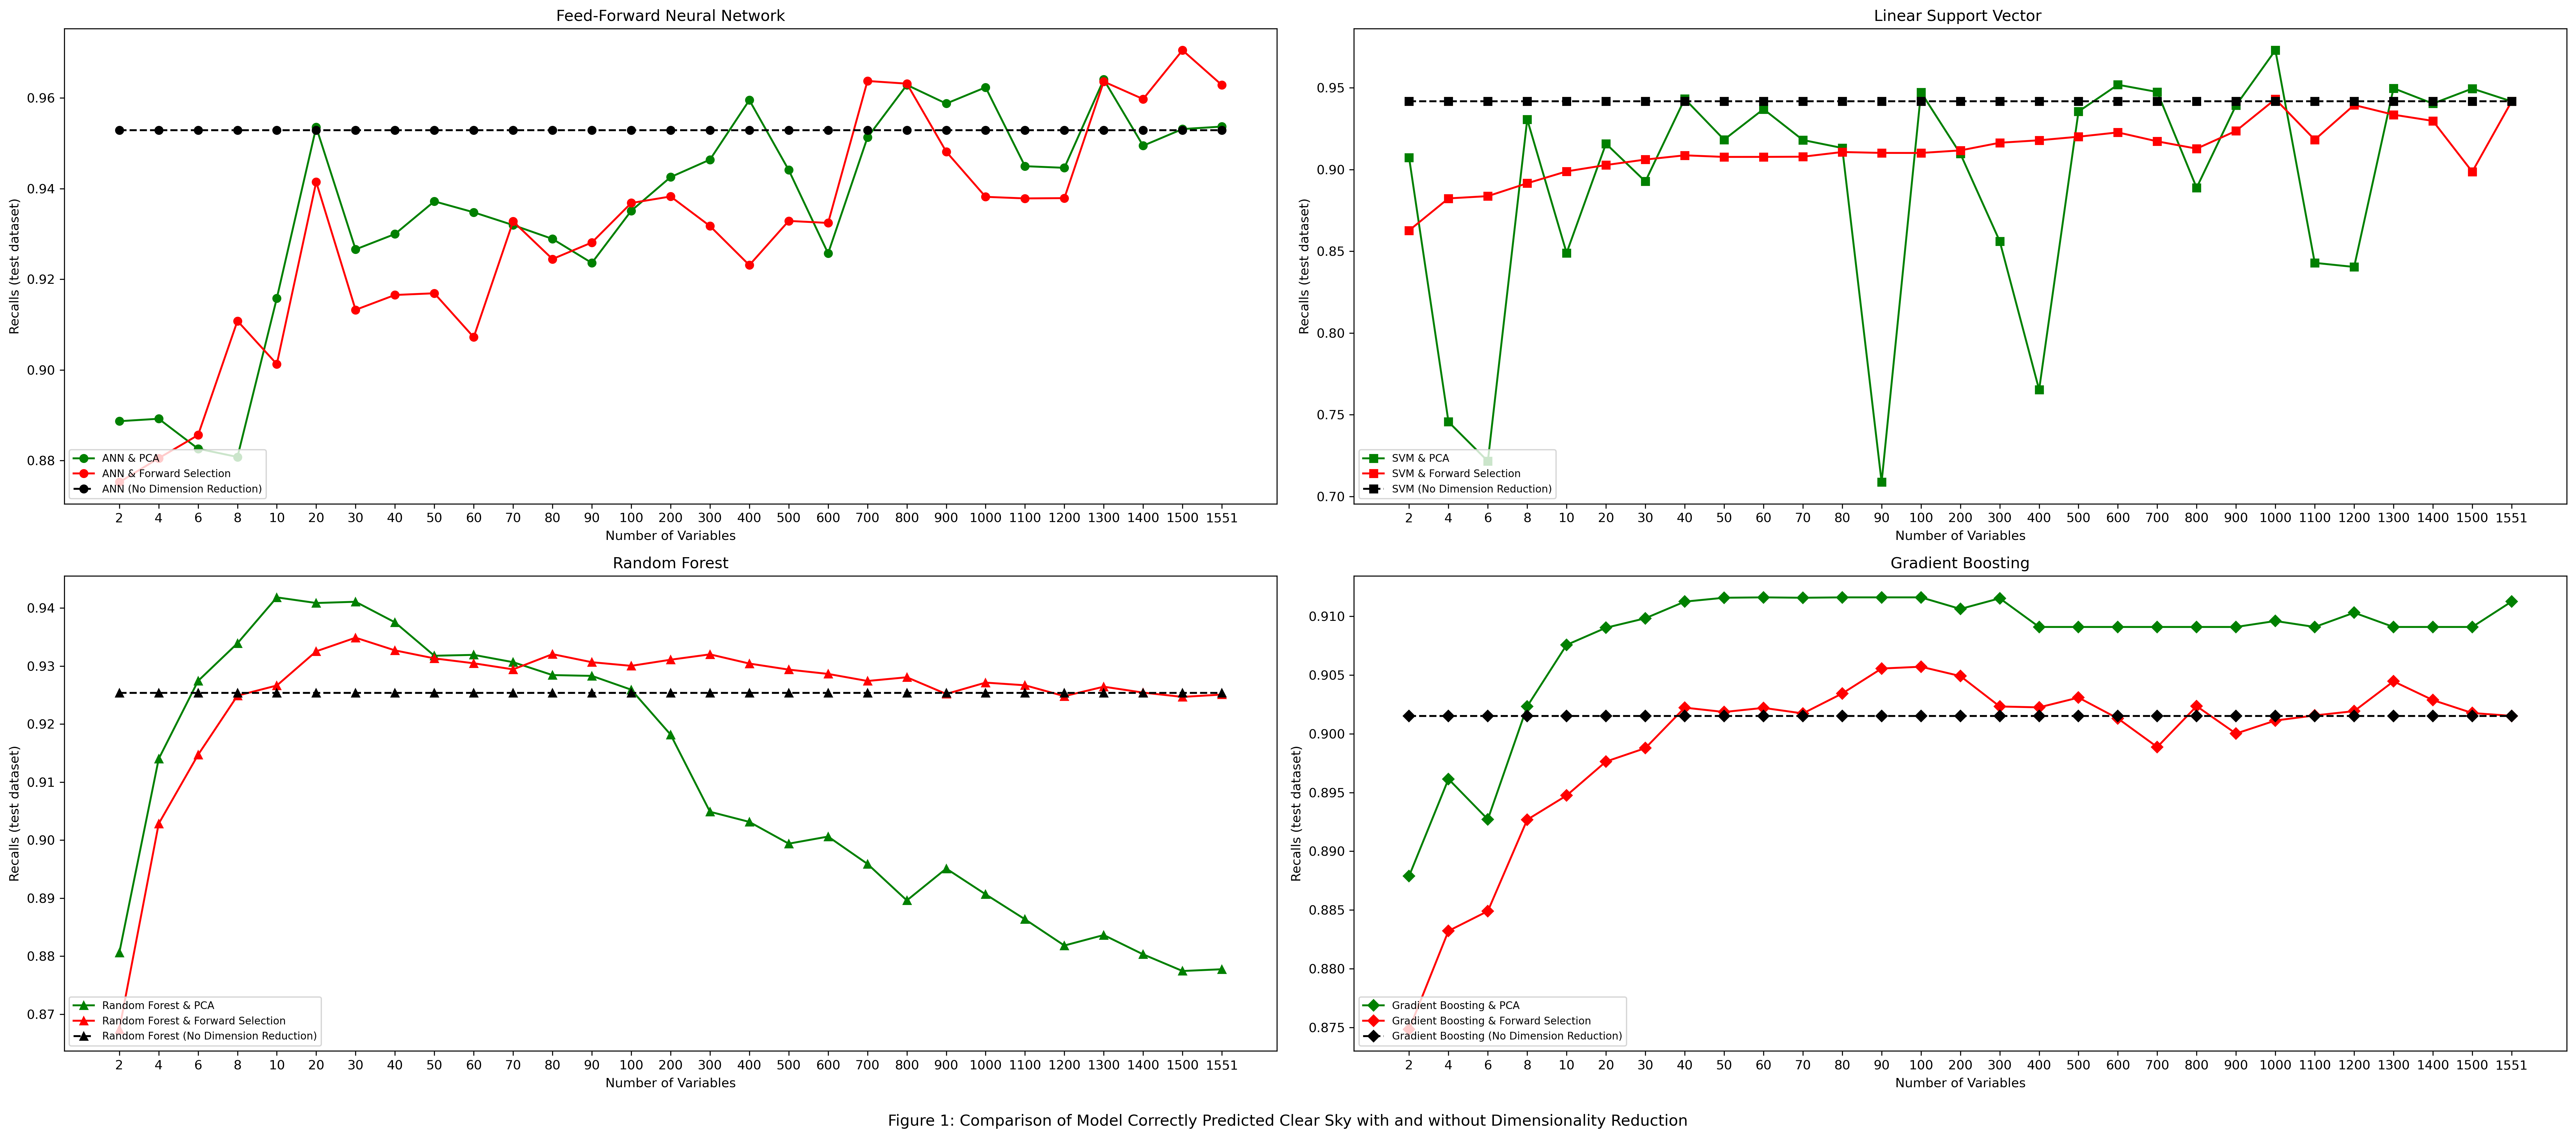

In [ ]:
x = reduced_num_list
indices = range(len(x))  # Generate indices for even spacing

# Create a 2x2 grid of subplots: F1 Scores
fig, axs = plt.subplots(2, 2, figsize=(28, 12), dpi = 300)

# First subplot
# axs[0, 0].plot(x, recalls_ann_autoencoder, label='ANN & Autoencoder', marker='o', color='b')
axs[0, 0].plot(indices, misclear_ann_pca, label='ANN & PCA', marker='o', color='g')
axs[0, 0].plot(indices, misclear_ann_bottleneck, label='ANN & Forward Selection', marker='o', color='r')
axs[0, 0].plot(indices, misclear_ann_nonreduction, linestyle='--', label='ANN (No Dimension Reduction)', marker='o', color='black')
axs[0, 0].set_xlabel('Number of Variables')
axs[0, 0].set_ylabel('Recalls (test dataset)')
axs[0, 0].set_title('Feed-Forward Neural Network')
axs[0, 0].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[0, 0].set_xticklabels(x)  # Label ticks with original 'x' values
axs[0, 0].legend(loc='lower left', fontsize=8)

# Second subplot
# axs[0, 1].plot(x, recalls_svm_autoencoder, label='SVM & Autoencoder', marker='s', color='b')
axs[0, 1].plot(indices, misclear_svm_pca, label='SVM & PCA', marker='s', color='g')
axs[0, 1].plot(indices, misclear_svm_bottleneck, label='SVM & Forward Selection', marker='s', color='r')
axs[0, 1].plot(indices, misclear_svm_nonreduction, linestyle='--', label='SVM (No Dimension Reduction)', marker='s', color='black')
axs[0, 1].set_xlabel('Number of Variables')
axs[0, 1].set_ylabel('Recalls (test dataset)')
axs[0, 1].set_title('Linear Support Vector ')
axs[0, 1].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[0, 1].set_xticklabels(x)  # Label ticks with original 'x' values
axs[0, 1].legend(loc='lower left', fontsize=8)

# Third subplot
# axs[1, 0].plot(x, recalls_rf_autoencoder, label='Random Forest & Autoencoder', marker='^', color='b')
axs[1, 0].plot(indices, misclear_rf_pca, label='Random Forest & PCA', marker='^', color='g')
axs[1, 0].plot(indices, misclear_rf_bottleneck, label='Random Forest & Forward Selection', marker='^', color='r')
axs[1, 0].plot(indices, misclear_rf_nonreduction, linestyle='--', label='Random Forest (No Dimension Reduction)', marker='^', color='black')
axs[1, 0].set_xlabel('Number of Variables')
axs[1, 0].set_ylabel('Recalls (test dataset)')
axs[1, 0].set_title('Random Forest')
axs[1, 0].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[1, 0].set_xticklabels(x)  # Label ticks with original 'x' values
axs[1, 0].legend(loc='lower left', fontsize=8)

# Fourth subplot
# axs[1, 1].plot(x, recalls_gb_autoencoder, label='Gradient Boosting & Autoencoder', marker='D', color='b')
axs[1, 1].plot(indices, misclear_gb_pca, label='Gradient Boosting & PCA', marker='D', color='g')
axs[1, 1].plot(indices, misclear_gb_bottleneck, label='Gradient Boosting & Forward Selection', marker='D', color='r')
axs[1, 1].plot(indices, misclear_gb_nonreduction, linestyle='--', label='Gradient Boosting (No Dimension Reduction)', marker='D', color='black')
axs[1, 1].set_xlabel('Number of Variables')
axs[1, 1].set_ylabel('Recalls (test dataset)')
axs[1, 1].set_title('Gradient Boosting')
axs[1, 1].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[1, 1].set_xticklabels(x)  # Label ticks with original 'x' values
axs[1, 1].legend(loc='lower left', fontsize=8)

# Adjust the layout
plt.tight_layout()

# Add a caption at the bottom of the figure
fig.text(0.5, -0.02, 'Figure 1: Comparison of Model Correctly Predicted Clear Sky with and without Dimensionality Reduction', ha='center', fontsize=12)


plt.savefig('Correctly Predicted Clear Sky Plot.png', bbox_inches='tight')

# Display the plot
plt.show()

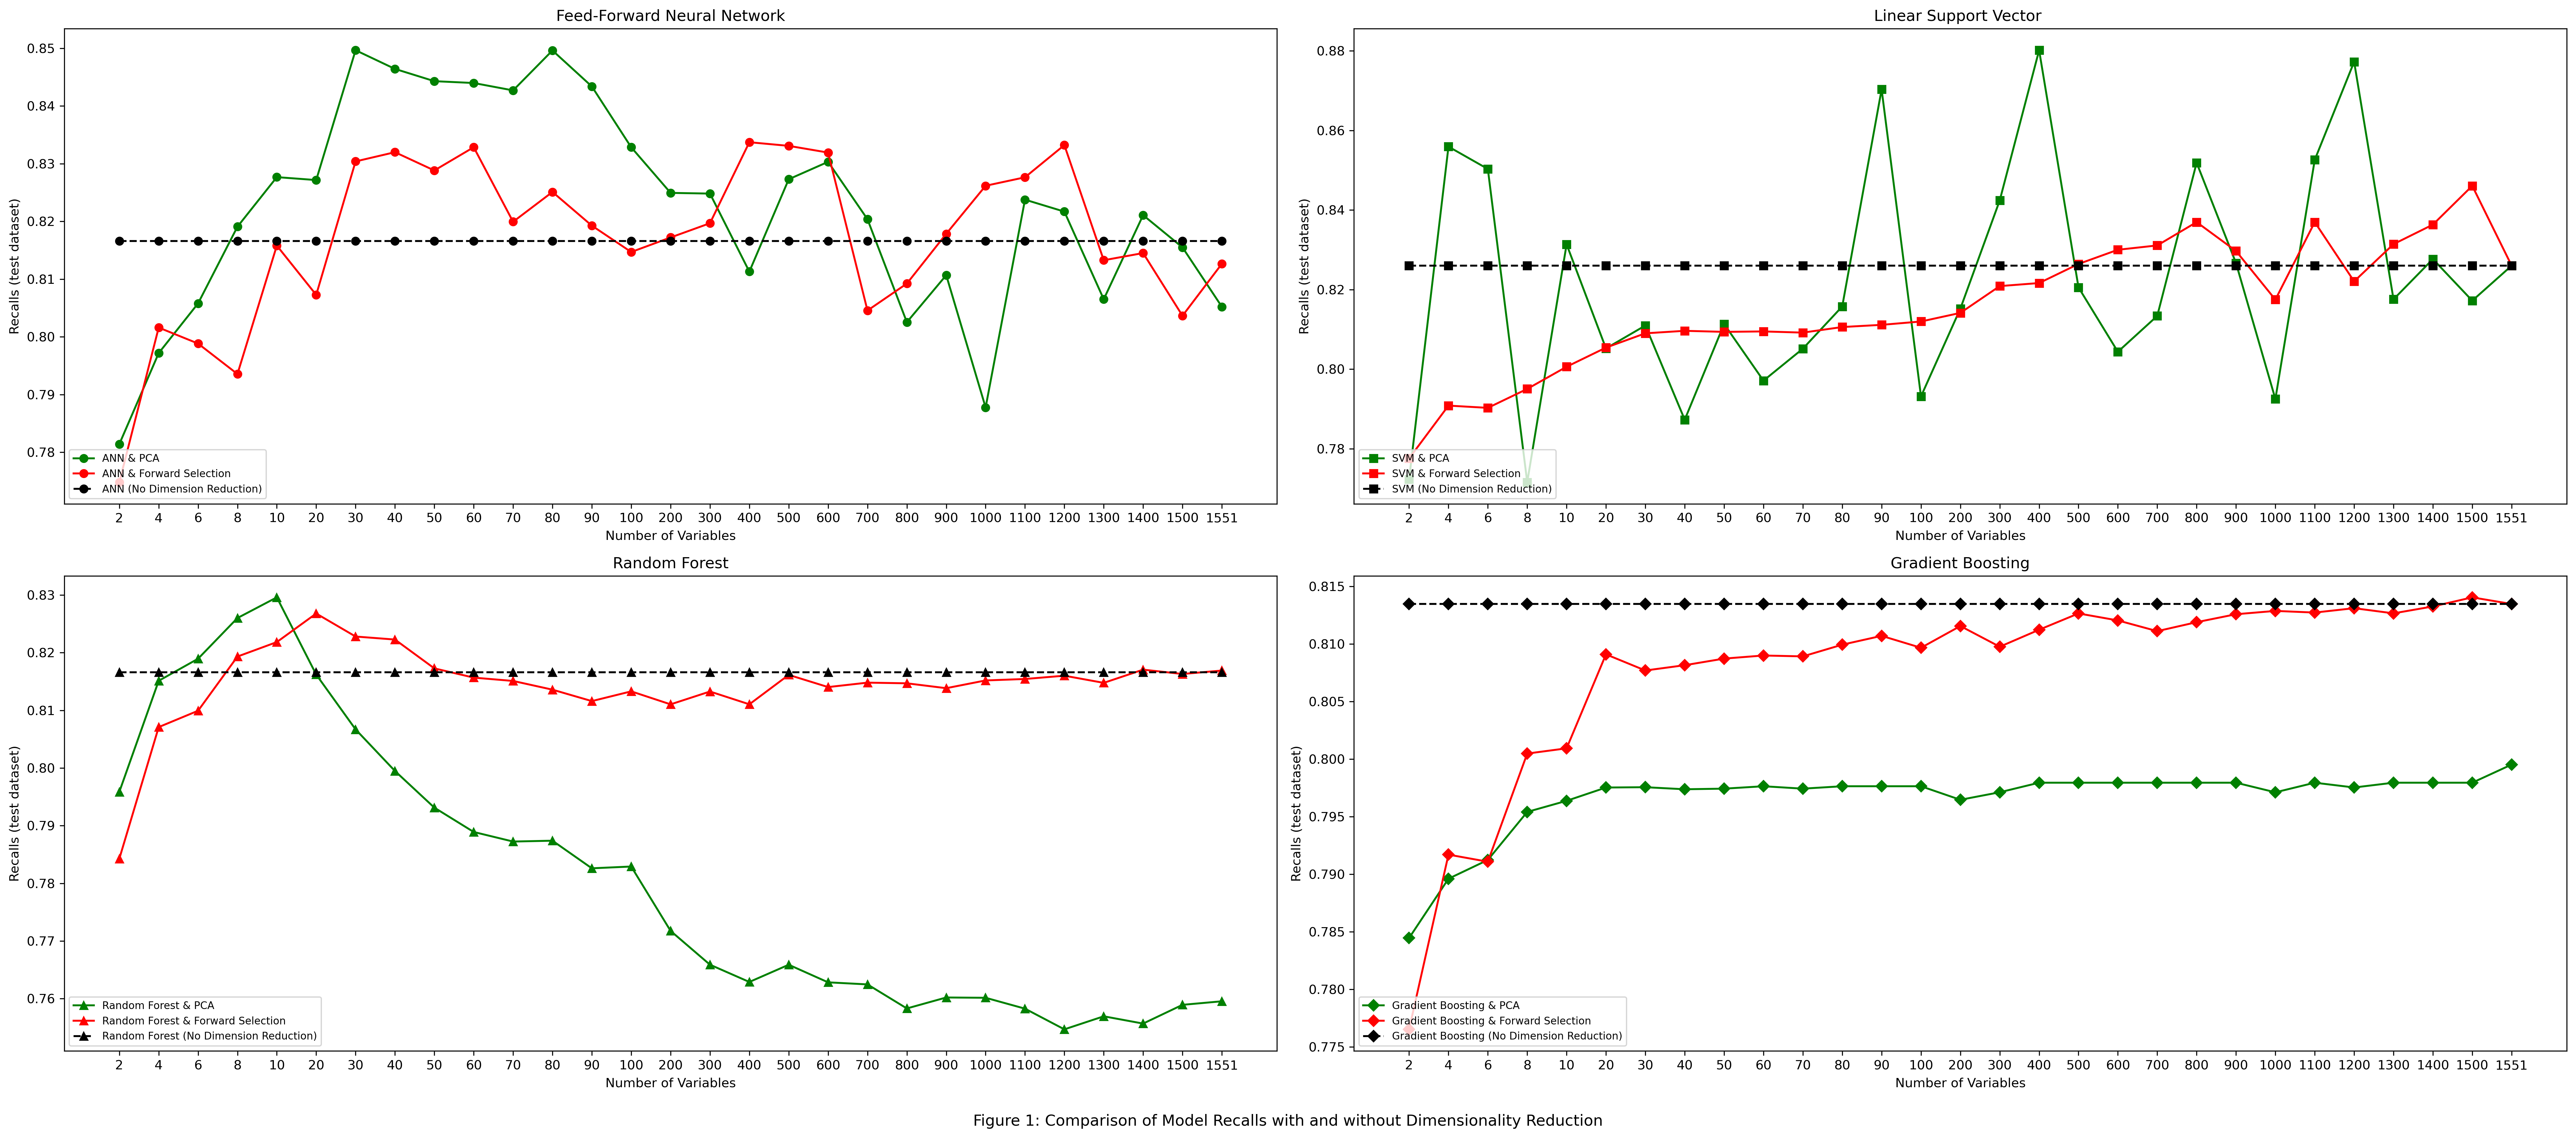

In [ ]:
x = reduced_num_list
indices = range(len(x))  # Generate indices for even spacing

# Create a 2x2 grid of subplots: F1 Scores
fig, axs = plt.subplots(2, 2, figsize=(28, 12), dpi = 300)

# First subplot
# axs[0, 0].plot(x, recalls_ann_autoencoder, label='ANN & Autoencoder', marker='o', color='b')
axs[0, 0].plot(indices, recalls_ann_pca, label='ANN & PCA', marker='o', color='g')
axs[0, 0].plot(indices, recalls_ann_bottleneck, label='ANN & Forward Selection', marker='o', color='r')
axs[0, 0].plot(indices, recalls_ann_nonreduction, linestyle='--', label='ANN (No Dimension Reduction)', marker='o', color='black')
axs[0, 0].set_xlabel('Number of Variables')
axs[0, 0].set_ylabel('Recalls (test dataset)')
axs[0, 0].set_title('Feed-Forward Neural Network')
axs[0, 0].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[0, 0].set_xticklabels(x)  # Label ticks with original 'x' values
axs[0, 0].legend(loc='lower left', fontsize=8)

# Second subplot
# axs[0, 1].plot(x, recalls_svm_autoencoder, label='SVM & Autoencoder', marker='s', color='b')
axs[0, 1].plot(indices, recalls_svm_pca, label='SVM & PCA', marker='s', color='g')
axs[0, 1].plot(indices, recalls_svm_bottleneck, label='SVM & Forward Selection', marker='s', color='r')
axs[0, 1].plot(indices, recalls_svm_nonreduction, linestyle='--', label='SVM (No Dimension Reduction)', marker='s', color='black')
axs[0, 1].set_xlabel('Number of Variables')
axs[0, 1].set_ylabel('Recalls (test dataset)')
axs[0, 1].set_title('Linear Support Vector ')
axs[0, 1].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[0, 1].set_xticklabels(x)  # Label ticks with original 'x' values
axs[0, 1].legend(loc='lower left', fontsize=8)

# Third subplot
# axs[1, 0].plot(x, recalls_rf_autoencoder, label='Random Forest & Autoencoder', marker='^', color='b')
axs[1, 0].plot(indices, recalls_rf_pca, label='Random Forest & PCA', marker='^', color='g')
axs[1, 0].plot(indices, recalls_rf_bottleneck, label='Random Forest & Forward Selection', marker='^', color='r')
axs[1, 0].plot(indices, recalls_rf_nonreduction, linestyle='--', label='Random Forest (No Dimension Reduction)', marker='^', color='black')
axs[1, 0].set_xlabel('Number of Variables')
axs[1, 0].set_ylabel('Recalls (test dataset)')
axs[1, 0].set_title('Random Forest')
axs[1, 0].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[1, 0].set_xticklabels(x)  # Label ticks with original 'x' values
axs[1, 0].legend(loc='lower left', fontsize=8)

# Fourth subplot
# axs[1, 1].plot(x, recalls_gb_autoencoder, label='Gradient Boosting & Autoencoder', marker='D', color='b')
axs[1, 1].plot(indices, recalls_gb_pca, label='Gradient Boosting & PCA', marker='D', color='g')
axs[1, 1].plot(indices, recalls_gb_bottleneck, label='Gradient Boosting & Forward Selection', marker='D', color='r')
axs[1, 1].plot(indices, recalls_gb_nonreduction, linestyle='--', label='Gradient Boosting (No Dimension Reduction)', marker='D', color='black')
axs[1, 1].set_xlabel('Number of Variables')
axs[1, 1].set_ylabel('Recalls (test dataset)')
axs[1, 1].set_title('Gradient Boosting')
axs[1, 1].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[1, 1].set_xticklabels(x)  # Label ticks with original 'x' values
axs[1, 1].legend(loc='lower left', fontsize=8)

# Adjust the layout
plt.tight_layout()

# Add a caption at the bottom of the figure
fig.text(0.5, -0.02, 'Figure 1: Comparison of Model Recalls with and without Dimensionality Reduction', ha='center', fontsize=12)


plt.savefig('Recalls Plot.png', bbox_inches='tight')

# Display the plot
plt.show()



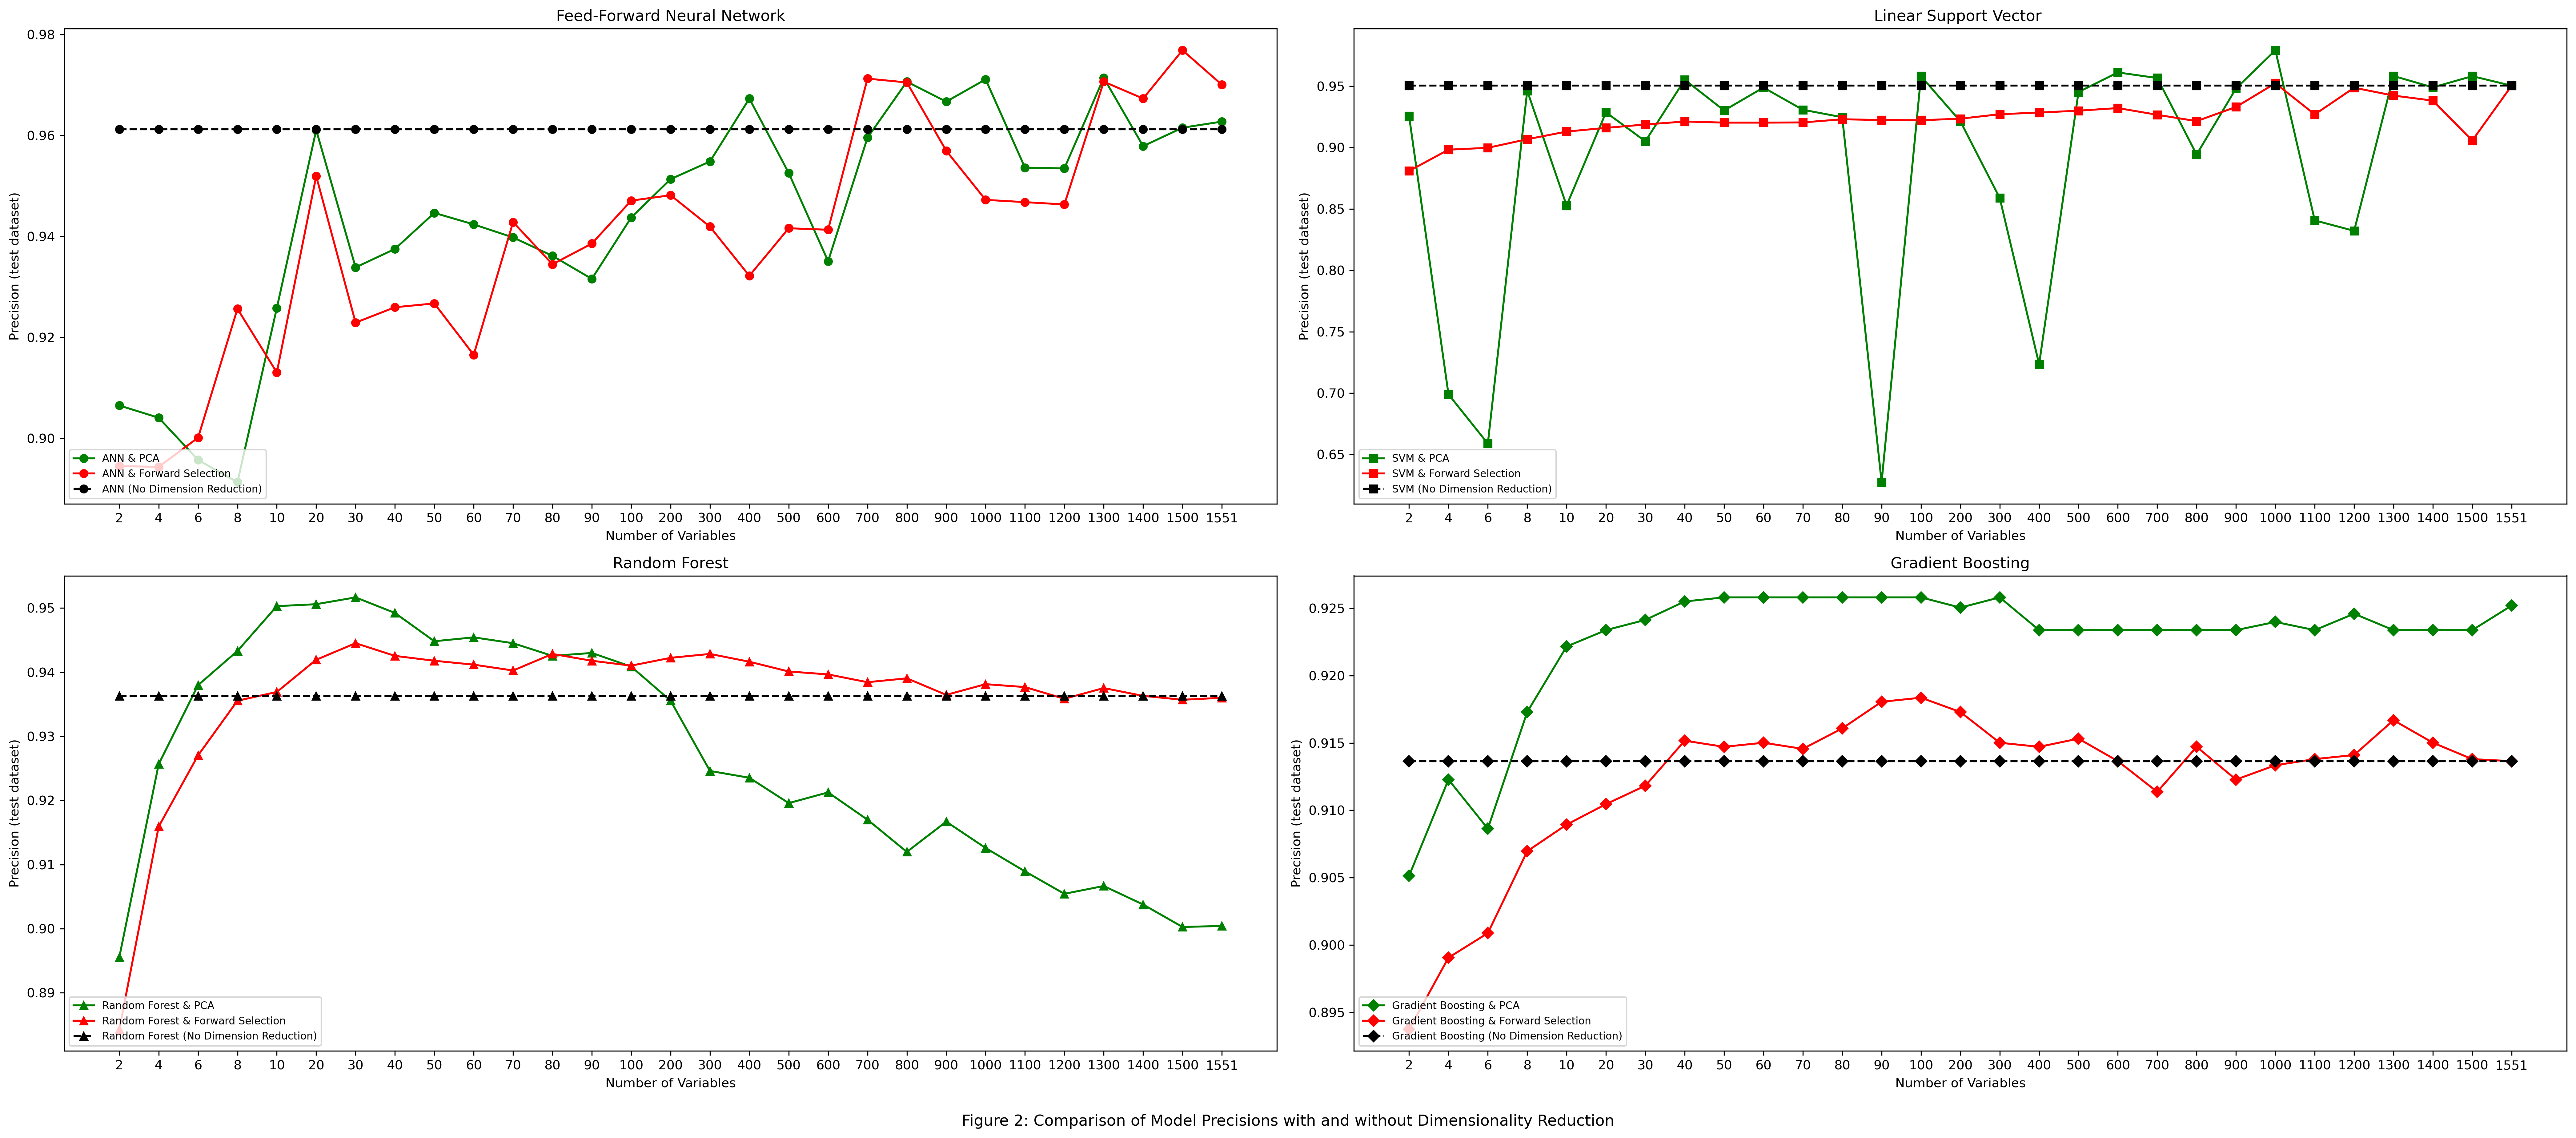

In [ ]:
x = reduced_num_list
indices = range(len(x))  # Generate indices for even spacing

# Create a 2x2 grid of subplots: F1 Scores
fig, axs = plt.subplots(2, 2, figsize=(28, 12), dpi = 300)

# First subplot
# axs[0, 0].plot(x, precisions_ann_autoencoder, label='ANN & Autoencoder', marker='o', color='b')
axs[0, 0].plot(indices, precisions_ann_pca, label='ANN & PCA', marker='o', color='g')
axs[0, 0].plot(indices, precisions_ann_bottleneck, label='ANN & Forward Selection', marker='o', color='r')
axs[0, 0].plot(indices, precisions_ann_nonreduction, linestyle='--', label='ANN (No Dimension Reduction)', marker='o', color='black')
axs[0, 0].set_xlabel('Number of Variables')
axs[0, 0].set_ylabel('Precision (test dataset)')
axs[0, 0].set_title('Feed-Forward Neural Network')
axs[0, 0].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[0, 0].set_xticklabels(x)  # Label ticks with original 'x' values
axs[0, 0].legend(loc='lower left', fontsize=8)

# Second subplot
# axs[0, 1].plot(x, precisions_svm_autoencoder, label='SVM & Autoencoder', marker='s', color='b')
axs[0, 1].plot(indices, precisions_svm_pca, label='SVM & PCA', marker='s', color='g')
axs[0, 1].plot(indices, precisions_svm_bottleneck, label='SVM & Forward Selection', marker='s', color='r')
axs[0, 1].plot(indices, precisions_svm_nonreduction, linestyle='--', label='SVM (No Dimension Reduction)', marker='s', color='black')
axs[0, 1].set_xlabel('Number of Variables')
axs[0, 1].set_ylabel('Precision (test dataset)')
axs[0, 1].set_title('Linear Support Vector ')
axs[0, 1].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[0, 1].set_xticklabels(x)  # Label ticks with original 'x' values
axs[0, 1].legend(loc='lower left', fontsize=8)

# Third subplot
# axs[1, 0].plot(x, precisions_rf_autoencoder, label='Random Forest & Autoencoder', marker='^', color='b')
axs[1, 0].plot(indices, precisions_rf_pca, label='Random Forest & PCA', marker='^', color='g')
axs[1, 0].plot(indices, precisions_rf_bottleneck, label='Random Forest & Forward Selection', marker='^', color='r')
axs[1, 0].plot(indices, precisions_rf_nonreduction, linestyle='--', label='Random Forest (No Dimension Reduction)', marker='^', color='black')
axs[1, 0].set_xlabel('Number of Variables')
axs[1, 0].set_ylabel('Precision (test dataset)')
axs[1, 0].set_title('Random Forest')
axs[1, 0].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[1, 0].set_xticklabels(x)  # Label ticks with original 'x' values
axs[1, 0].legend(loc='lower left', fontsize=8)

# Fourth subplot
# axs[1, 1].plot(x, precisions_gb_autoencoder, label='Gradient Boosting & Autoencoder', marker='D', color='b')
axs[1, 1].plot(indices, precisions_gb_pca, label='Gradient Boosting & PCA', marker='D', color='g')
axs[1, 1].plot(indices, precisions_gb_bottleneck, label='Gradient Boosting & Forward Selection', marker='D', color='r')
axs[1, 1].plot(indices, precisions_gb_nonreduction, linestyle='--', label='Gradient Boosting (No Dimension Reduction)', marker='D', color='black')
axs[1, 1].set_xlabel('Number of Variables')
axs[1, 1].set_ylabel('Precision (test dataset)')
axs[1, 1].set_title('Gradient Boosting')
axs[1, 1].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[1, 1].set_xticklabels(x)  # Label ticks with original 'x' values
axs[1, 1].legend(loc='lower left', fontsize=8)

# Adjust the layout
plt.tight_layout()

# Add a caption at the bottom of the figure
fig.text(0.5, -0.02, 'Figure 2: Comparison of Model Precisions with and without Dimensionality Reduction', ha='center', fontsize=12)


plt.savefig('Precision Plot.png', bbox_inches='tight')

# Display the plot
plt.show()

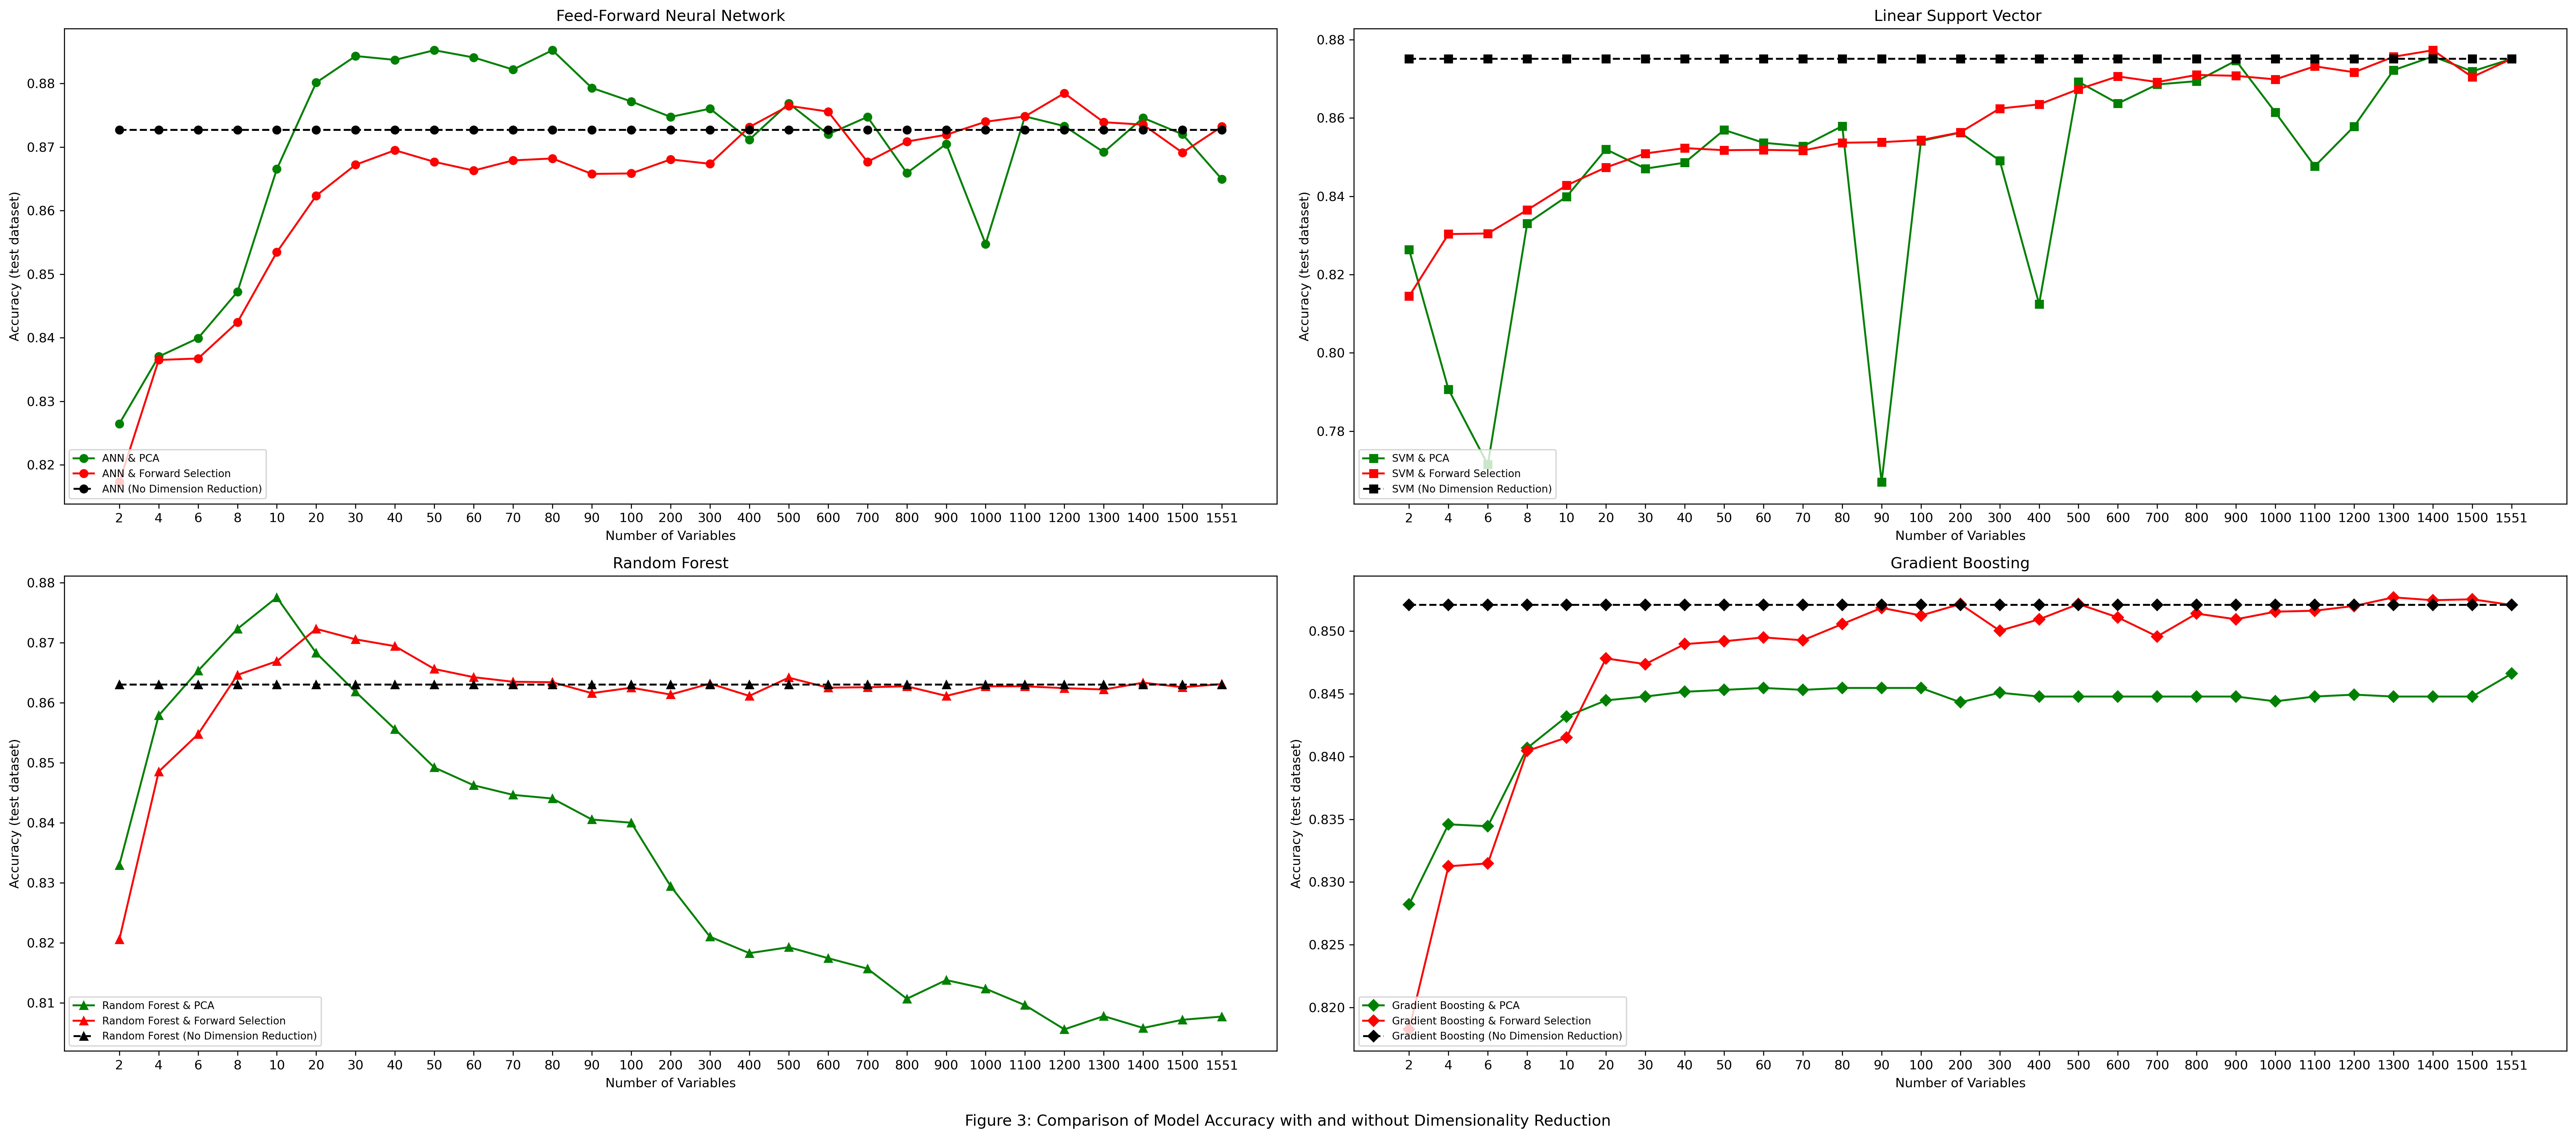

In [ ]:
x = reduced_num_list
indices = range(len(x))  # Generate indices for even spacing

# Create a 2x2 grid of subplots: F1 Scores
fig, axs = plt.subplots(2, 2, figsize=(28, 12), dpi = 300)

# First subplot
# axs[0, 0].plot(x, accuracies_ann_autoencoder, label='ANN & Autoencoder', marker='o', color='b')
axs[0, 0].plot(indices, accuracies_ann_pca, label='ANN & PCA', marker='o', color='g')
axs[0, 0].plot(indices, accuracies_ann_bottleneck, label='ANN & Forward Selection', marker='o', color='r')
axs[0, 0].plot(indices, accuracies_ann_nonreduction, linestyle='--', label='ANN (No Dimension Reduction)', marker='o', color='black')
axs[0, 0].set_xlabel('Number of Variables')
axs[0, 0].set_ylabel('Accuracy (test dataset)')
axs[0, 0].set_title('Feed-Forward Neural Network')
axs[0, 0].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[0, 0].set_xticklabels(x)  # Label ticks with original 'x' values
axs[0, 0].legend(loc='lower left', fontsize=8)

# Second subplot
# axs[0, 1].plot(x, accuracies_svm_autoencoder, label='SVM & Autoencoder', marker='s', color='b')
axs[0, 1].plot(indices, accuracies_svm_pca, label='SVM & PCA', marker='s', color='g')
axs[0, 1].plot(indices, accuracies_svm_bottleneck, label='SVM & Forward Selection', marker='s', color='r')
axs[0, 1].plot(indices, accuracies_svm_nonreduction, linestyle='--', label='SVM (No Dimension Reduction)', marker='s', color='black')
axs[0, 1].set_xlabel('Number of Variables')
axs[0, 1].set_ylabel('Accuracy (test dataset)')
axs[0, 1].set_title('Linear Support Vector ')
axs[0, 1].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[0, 1].set_xticklabels(x)  # Label ticks with original 'x' values
axs[0, 1].legend(loc='lower left', fontsize=8)

# Third subplot
# axs[1, 0].plot(x, accuracies_rf_autoencoder, label='Random Forest & Autoencoder', marker='^', color='b')
axs[1, 0].plot(indices, accuracies_rf_pca, label='Random Forest & PCA', marker='^', color='g')
axs[1, 0].plot(indices, accuracies_rf_bottleneck, label='Random Forest & Forward Selection', marker='^', color='r')
axs[1, 0].plot(indices, accuracies_rf_nonreduction, linestyle='--', label='Random Forest (No Dimension Reduction)', marker='^', color='black')
axs[1, 0].set_xlabel('Number of Variables')
axs[1, 0].set_ylabel('Accuracy (test dataset)')
axs[1, 0].set_title('Random Forest')
axs[1, 0].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[1, 0].set_xticklabels(x)  # Label ticks with original 'x' values
axs[1, 0].legend(loc='lower left', fontsize=8)

# Fourth subplot
# axs[1, 1].plot(x, accuracies_gb_autoencoder, label='Gradient Boosting & Autoencoder', marker='D', color='b')
axs[1, 1].plot(indices, accuracies_gb_pca, label='Gradient Boosting & PCA', marker='D', color='g')
axs[1, 1].plot(indices, accuracies_gb_bottleneck, label='Gradient Boosting & Forward Selection', marker='D', color='r')
axs[1, 1].plot(indices, accuracies_gb_nonreduction, linestyle='--', label='Gradient Boosting (No Dimension Reduction)', marker='D', color='black')
axs[1, 1].set_xlabel('Number of Variables')
axs[1, 1].set_ylabel('Accuracy (test dataset)')
axs[1, 1].set_title('Gradient Boosting')
axs[1, 1].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[1, 1].set_xticklabels(x)  # Label ticks with original 'x' values
axs[1, 1].legend(loc='lower left', fontsize=8)

# Adjust the layout
plt.tight_layout()

# Add a caption at the bottom of the figure
fig.text(0.5, -0.02, 'Figure 3: Comparison of Model Accuracy with and without Dimensionality Reduction', ha='center', fontsize=12)


plt.savefig('Accuracy Plot.png', bbox_inches='tight')

# Display the plot
plt.show()

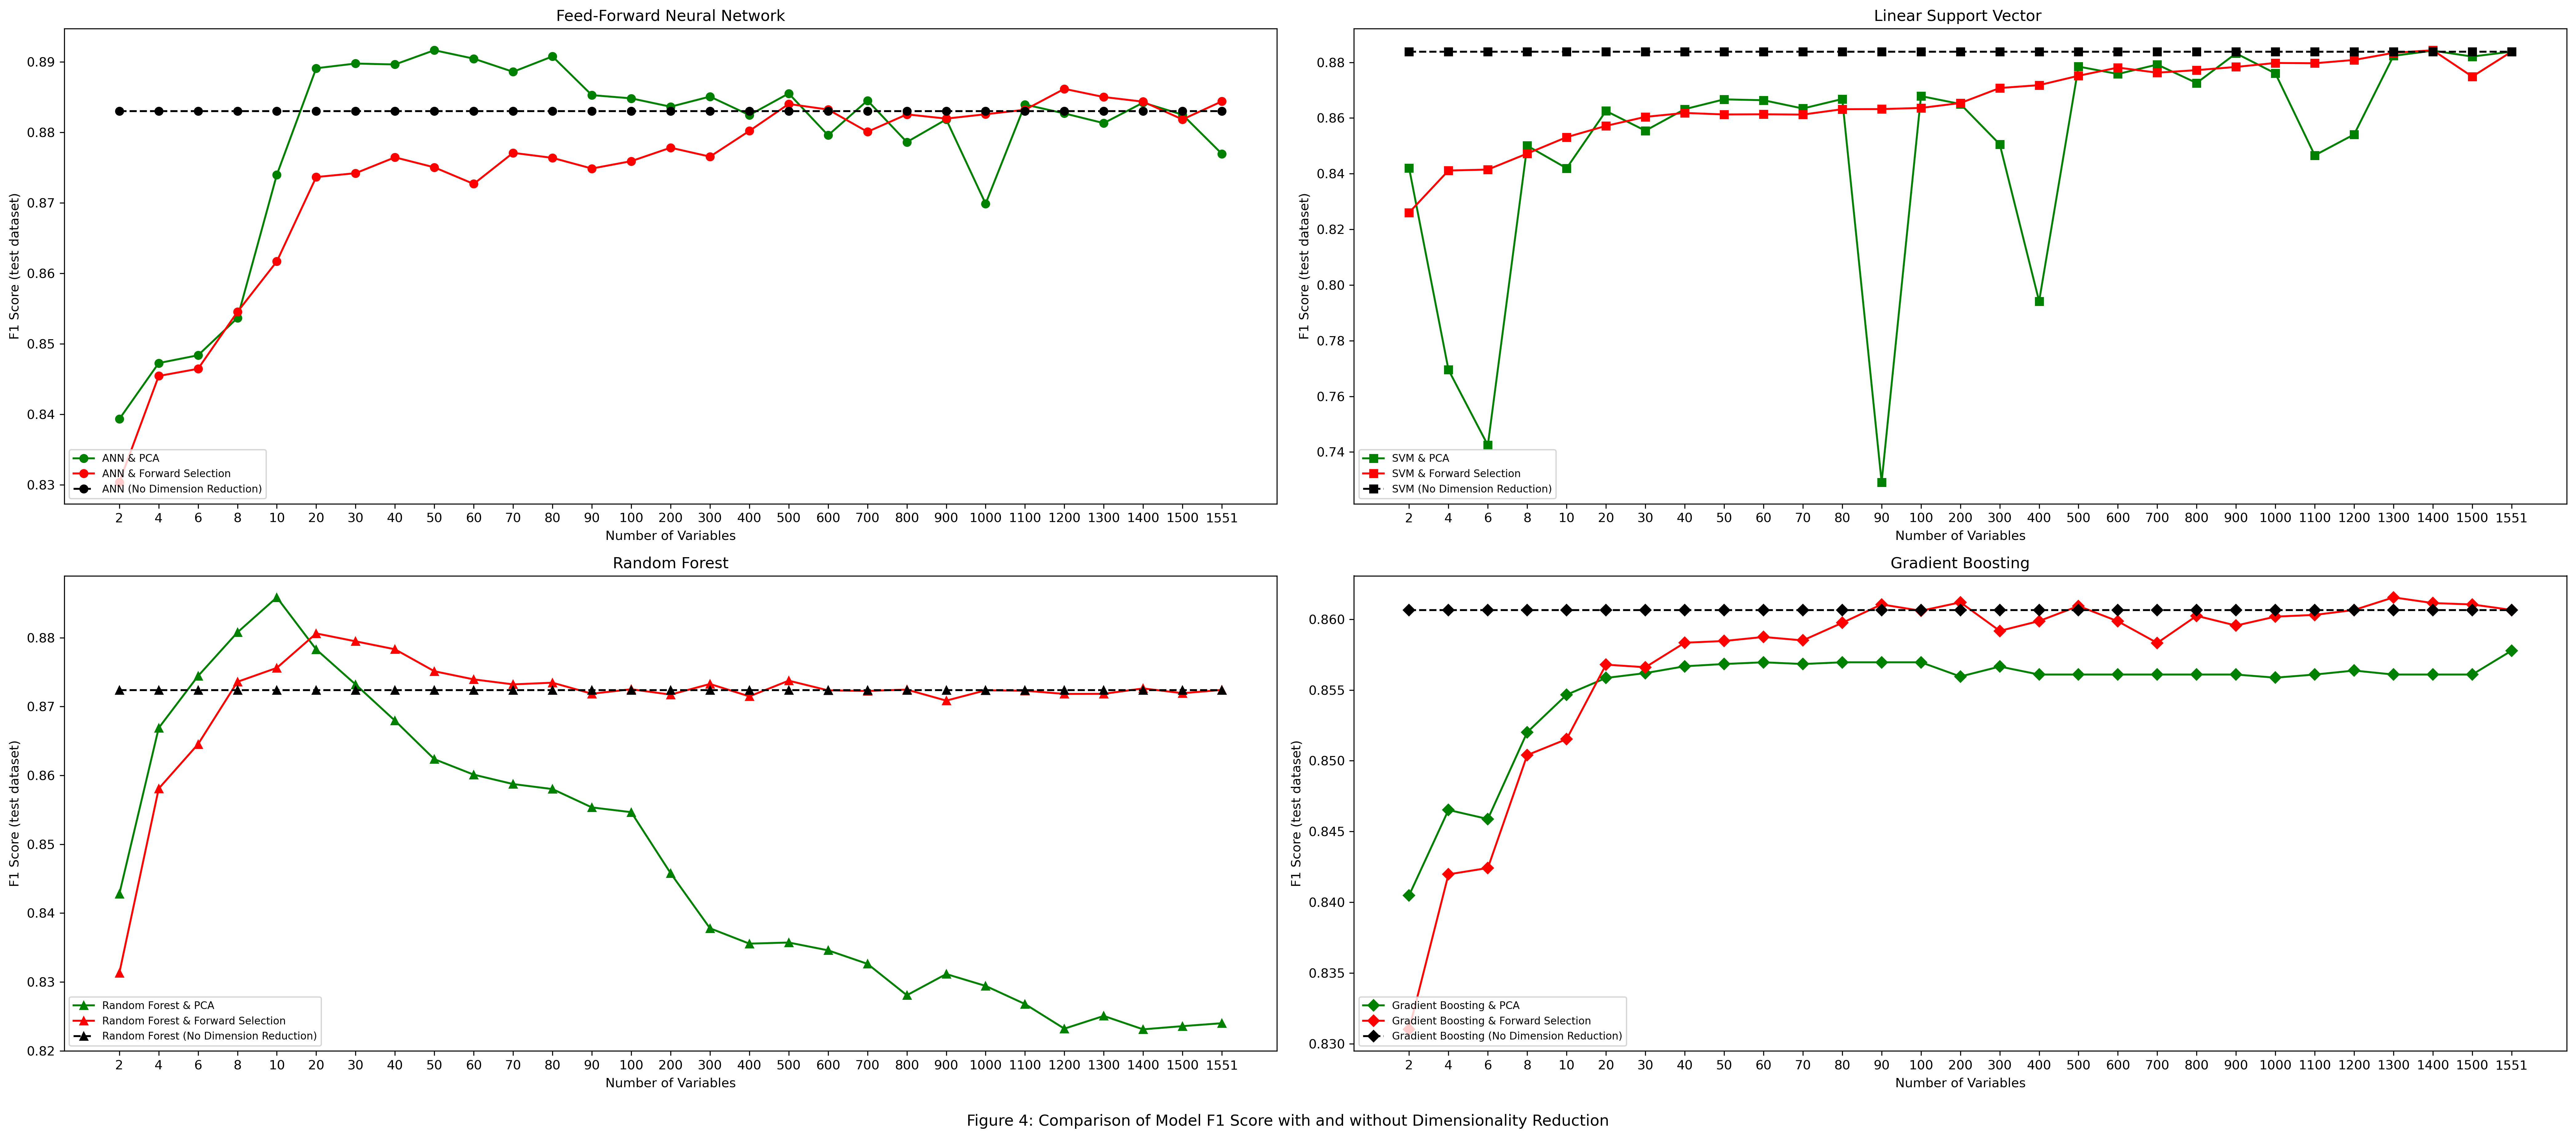

In [ ]:
x = reduced_num_list
indices = range(len(x))  # Generate indices for even spacing

# Create a 2x2 grid of subplots: F1 Scores
fig, axs = plt.subplots(2, 2, figsize=(28, 12), dpi = 300)

# First subplot
# axs[0, 0].plot(x, f1_scores_ann_autoencoder, label='ANN & Autoencoder', marker='o', color='b')
axs[0, 0].plot(indices, f1_scores_ann_pca, label='ANN & PCA', marker='o', color='g')
axs[0, 0].plot(indices, f1_scores_ann_bottleneck, label='ANN & Forward Selection', marker='o', color='r')
axs[0, 0].plot(indices, f1_scores_ann_nonreduction, linestyle='--', label='ANN (No Dimension Reduction)', marker='o', color='black')
axs[0, 0].set_xlabel('Number of Variables')
axs[0, 0].set_ylabel('F1 Score (test dataset)')
axs[0, 0].set_title('Feed-Forward Neural Network')
axs[0, 0].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[0, 0].set_xticklabels(x)  # Label ticks with original 'x' values
axs[0, 0].legend(loc='lower left', fontsize=8)

# Second subplot
# axs[0, 1].plot(x, f1_scores_svm_autoencoder, label='SVM & Autoencoder', marker='s', color='b')
axs[0, 1].plot(indices, f1_scores_svm_pca, label='SVM & PCA', marker='s', color='g')
axs[0, 1].plot(indices, f1_scores_svm_bottleneck, label='SVM & Forward Selection', marker='s', color='r')
axs[0, 1].plot(indices, f1_scores_svm_nonreduction, linestyle='--', label='SVM (No Dimension Reduction)', marker='s', color='black')
axs[0, 1].set_xlabel('Number of Variables')
axs[0, 1].set_ylabel('F1 Score (test dataset)')
axs[0, 1].set_title('Linear Support Vector ')
axs[0, 1].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[0, 1].set_xticklabels(x)  # Label ticks with original 'x' values
axs[0, 1].legend(loc='lower left', fontsize=8)

# Third subplot
# axs[1, 0].plot(x, f1_scores_rf_autoencoder, label='Random Forest & Autoencoder', marker='^', color='b')
axs[1, 0].plot(indices, f1_scores_rf_pca, label='Random Forest & PCA', marker='^', color='g')
axs[1, 0].plot(indices, f1_scores_rf_bottleneck, label='Random Forest & Forward Selection', marker='^', color='r')
axs[1, 0].plot(indices, f1_scores_rf_nonreduction, linestyle='--', label='Random Forest (No Dimension Reduction)', marker='^', color='black')
axs[1, 0].set_xlabel('Number of Variables')
axs[1, 0].set_ylabel('F1 Score (test dataset)')
axs[1, 0].set_title('Random Forest')
axs[1, 0].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[1, 0].set_xticklabels(x)  # Label ticks with original 'x' values
axs[1, 0].legend(loc='lower left', fontsize=8)

# Fourth subplot
# axs[1, 1].plot(x, f1_scores_gb_autoencoder, label='Gradient Boosting & Autoencoder', marker='D', color='b')
axs[1, 1].plot(indices, f1_scores_gb_pca, label='Gradient Boosting & PCA', marker='D', color='g')
axs[1, 1].plot(indices, f1_scores_gb_bottleneck, label='Gradient Boosting & Forward Selection', marker='D', color='r')
axs[1, 1].plot(indices, f1_scores_gb_nonreduction, linestyle='--', label='Gradient Boosting (No Dimension Reduction)', marker='D', color='black')
axs[1, 1].set_xlabel('Number of Variables')
axs[1, 1].set_ylabel('F1 Score (test dataset)')
axs[1, 1].set_title('Gradient Boosting')
axs[1, 1].set_xticks(indices)  # Ensure all indices are shown as ticks
axs[1, 1].set_xticklabels(x)  # Label ticks with original 'x' values
axs[1, 1].legend(loc='lower left', fontsize=8)

# Adjust the layout
plt.tight_layout()

# Add a caption at the bottom of the figure
fig.text(0.5, -0.02, 'Figure 4: Comparison of Model F1 Score with and without Dimensionality Reduction', ha='center', fontsize=12)


plt.savefig('F1 Score Plot.png', bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
# # Plot confusion matrix
# fig, ax = plt.subplots(figsize=(6,6),constrained_layout=True)

# plot_confusion_matrix_2(y_pred_autoencoder, y_test, display_labels=['Clear Sky', 'Cloudy Sky'],
#                         cmap=plt.cm.Blues, ax=ax)

In [ ]:
# history = pd.read_csv(filename + '.log', sep=',', engine='python')
# fig, ax = plt.subplots(1,2,figsize=(10,6))

# # summarize history for loss
# ax[0].plot(history.loss)
# ax[0].plot(history.val_loss)
# ax[0].set_ylabel('Loss')
# ax[0].set_xlabel('Epoch')
# ax[0].legend(['Training', 'Validation'])

# # summarize history for accuracy
# ax[1].plot(history.accuracy)
# ax[1].plot(history.val_accuracy)
# ax[1].set_ylabel('Accuracy')
# ax[1].set_xlabel('Epoch')
# ax[1].legend(['Training', 'Validation'])

# plt.show()